<a href="https://colab.research.google.com/github/MohamamdAghaei/Acea-Smart-Water-Analytics/blob/main/Big_Data_project_Water_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importig and understanding data**

In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 17.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy.stats import kstest, norm
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
#Reading dataset
df = pd.read_csv('/content/lakes_fe.csv')

In [6]:
#Checking shape and size of the dataset
df.shape

(6603, 5)

In [7]:
df.head()

Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate  Actual_Lake_Level
0     0       2.857312  14.530141          2.578255         249.606745
1     1       2.857312  14.530141          2.578255         249.606745
2     2       2.857312  14.530141          2.578255         249.606745
3     3       2.857312  14.530141          2.578255         249.606745
4     4       2.857312  14.530141          2.578255         249.606745

In [8]:
#Finfing information and simultaneously finding Null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               6603 non-null   int64  
 1   Mean_Rainfall      6603 non-null   float64
 2   Mean_Temp          6603 non-null   float64
 3   Actual_Flow_Rate   6603 non-null   float64
 4   Actual_Lake_Level  6603 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 258.1 KB


# **Preparing Data**

In [9]:
#Checking missing values
df.isnull().sum()

Date                 0
Mean_Rainfall        0
Mean_Temp            0
Actual_Flow_Rate     0
Actual_Lake_Level    0
dtype: int64

In [10]:
#Cheking duplicate roes
print(df.duplicated().sum())

0


In [11]:
# Convert the 'Date' column to datetime format
# Assuming day 0 is '01/01/2006'
start_date = datetime(2006, 7, 1)
df['Date'] = start_date + pd.to_timedelta(df['Date'], unit='D')

# Display the DataFrame
df.head()

Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate  Actual_Lake_Level
0 2006-07-01       2.857312  14.530141          2.578255         249.606745
1 2006-07-02       2.857312  14.530141          2.578255         249.606745
2 2006-07-03       2.857312  14.530141          2.578255         249.606745
3 2006-07-04       2.857312  14.530141          2.578255         249.606745
4 2006-07-05       2.857312  14.530141          2.578255         249.606745

In [12]:
# check type of the dataset columns

df.dtypes

Date                 datetime64[ns]
Mean_Rainfall               float64
Mean_Temp                   float64
Actual_Flow_Rate            float64
Actual_Lake_Level           float64
dtype: object

# **EDA**

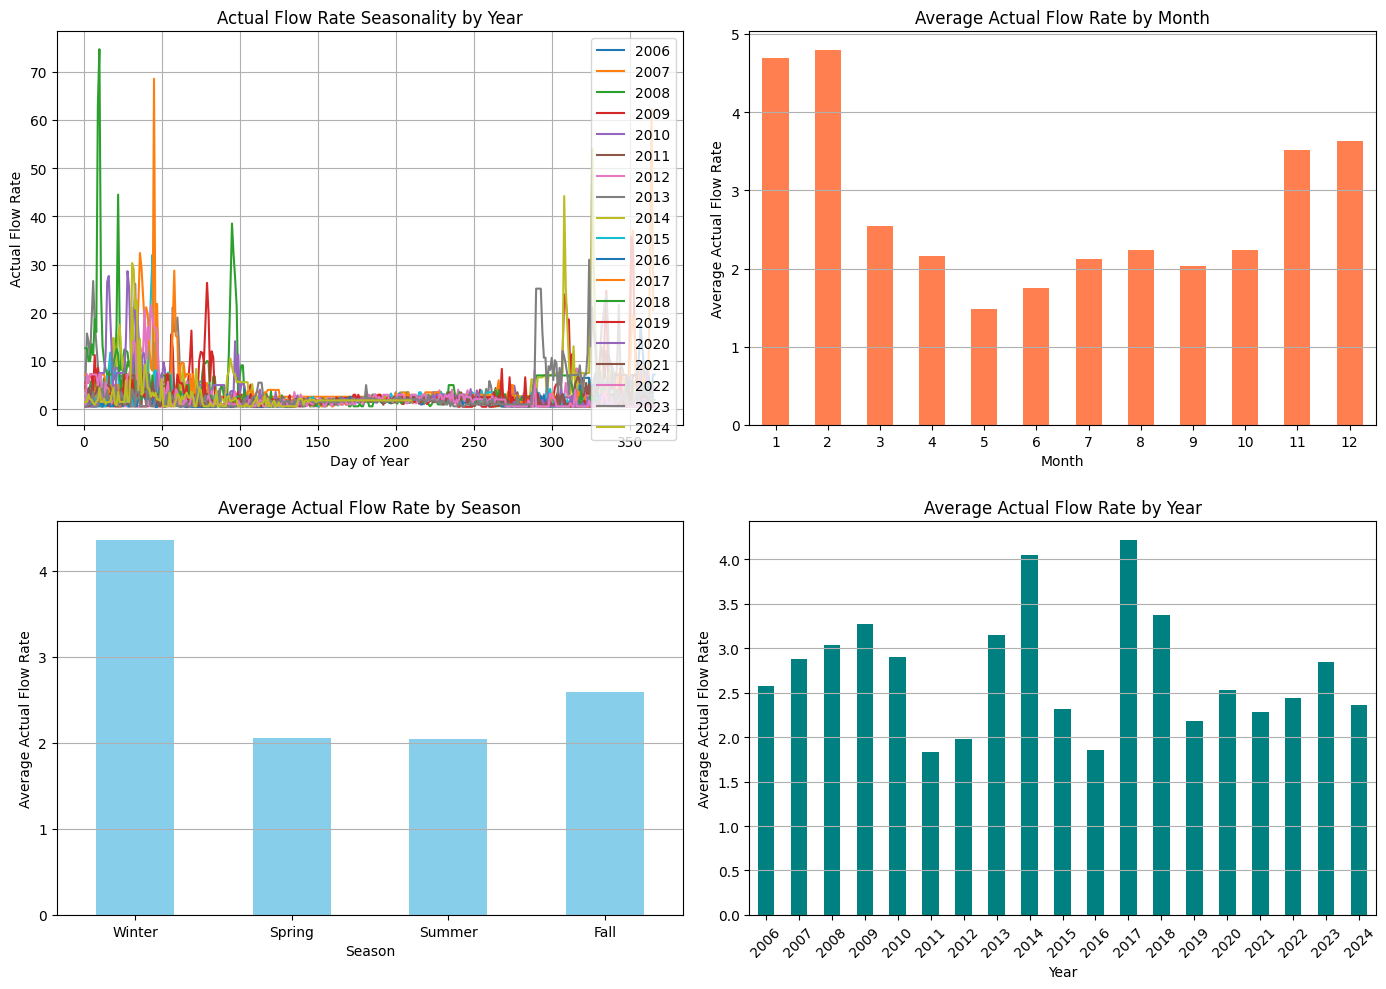

In [13]:
# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_use = df.copy()

# Ensure 'Date' column is in datetime format
df_use['Date'] = pd.to_datetime(df_use['Date'])

# Plot 1: Daily flow rates by year
df_use['year'] = df_use['Date'].dt.year
df_use['day_of_year'] = df_use['Date'].dt.dayofyear

for year in df_use['year'].unique():
    year_data = df_use[df_use['year'] == year]
    axes[0, 0].plot(year_data['day_of_year'], year_data['Actual_Flow_Rate'], label=str(year))

axes[0, 0].set_xlabel('Day of Year')
axes[0, 0].set_ylabel('Actual Flow Rate')
axes[0, 0].set_title('Actual Flow Rate Seasonality by Year')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Monthly average flow rates
df_use['month'] = df_use['Date'].dt.month
monthly_flow_rate = df_use.groupby('month')['Actual_Flow_Rate'].mean()
monthly_flow_rate.plot(kind='bar', color='coral', ax=axes[0, 1])
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Actual Flow Rate')
axes[0, 1].set_title('Average Actual Flow Rate by Month')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(axis='y')

# Plot 3: Seasonal average flow rates
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_use['Season'] = df_use['Date'].apply(get_season)
seasonal_flow_rate = df_use.groupby('Season')['Actual_Flow_Rate'].mean()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_flow_rate.reindex(season_order).plot(kind='bar', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Average Actual Flow Rate')
axes[1, 0].set_title('Average Actual Flow Rate by Season')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(axis='y')

# Plot 4: Yearly average flow rates
yearly_flow_rate = df_use.groupby('year')['Actual_Flow_Rate'].mean()
yearly_flow_rate.plot(kind='bar', color='teal', ax=axes[1, 1])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Actual Flow Rate')
axes[1, 1].set_title('Average Actual Flow Rate by Year')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].grid(axis='y')

# Improve spacing between plots
plt.tight_layout()
plt.show()


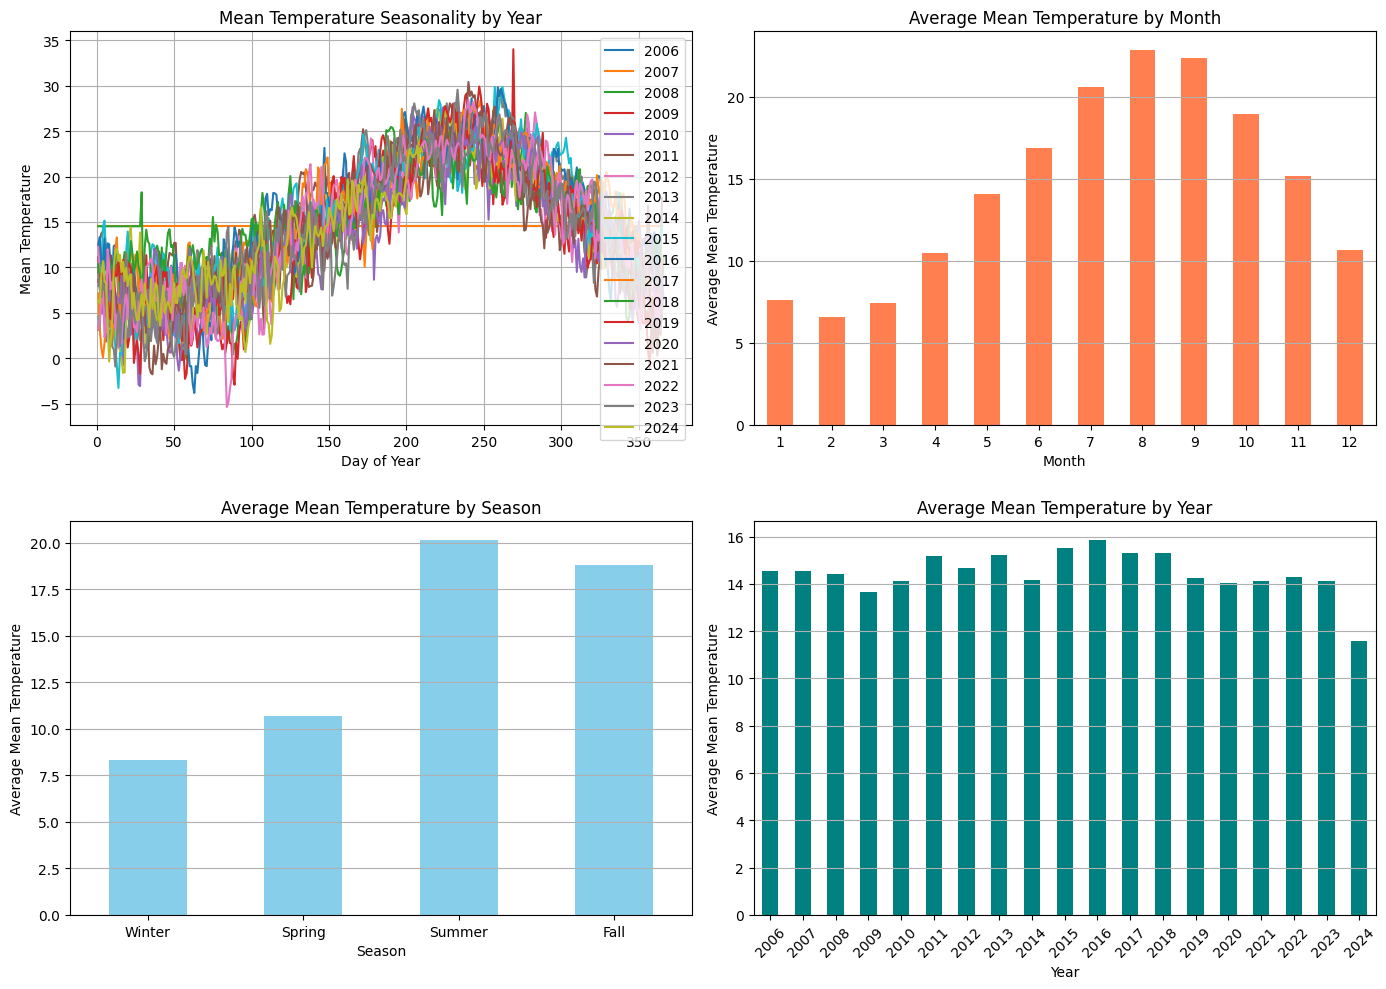

In [14]:
# Create a set of plots to analyze Mean_Temp patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_temp = df.copy()

# Convert 'Date' to datetime format if needed
df_temp['Date'] = pd.to_datetime(df_temp['Date'])

# Plot 1: Mean_Temp over the year for each individual year
df_temp['year'] = df_temp['Date'].dt.year
df_temp['day_of_year'] = df_temp['Date'].dt.dayofyear

for year in df_temp['year'].unique():
    year_data = df_temp[df_temp['year'] == year]
    axes[0, 0].plot(year_data['day_of_year'], year_data['Mean_Temp'], label=str(year))

axes[0, 0].set_xlabel('Day of Year')
axes[0, 0].set_ylabel('Mean Temperature')
axes[0, 0].set_title('Mean Temperature Seasonality by Year')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Monthly average of Mean_Temp
df_temp['month'] = df_temp['Date'].dt.month
monthly_temp = df_temp.groupby('month')['Mean_Temp'].mean()
monthly_temp.plot(kind='bar', color='coral', ax=axes[0, 1])
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Mean Temperature')
axes[0, 1].set_title('Average Mean Temperature by Month')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(axis='y')

# Plot 3: Seasonal average of Mean_Temp
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_temp['Season'] = df_temp['Date'].apply(get_season)
seasonal_temp = df_temp.groupby('Season')['Mean_Temp'].mean()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_temp.reindex(season_order).plot(kind='bar', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Average Mean Temperature')
axes[1, 0].set_title('Average Mean Temperature by Season')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(axis='y')

# Plot 4: Yearly average of Mean_Temp
yearly_temp = df_temp.groupby('year')['Mean_Temp'].mean()
yearly_temp.plot(kind='bar', color='teal', ax=axes[1, 1])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Mean Temperature')
axes[1, 1].set_title('Average Mean Temperature by Year')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].grid(axis='y')

# Improve layout spacing
plt.tight_layout()
plt.show()


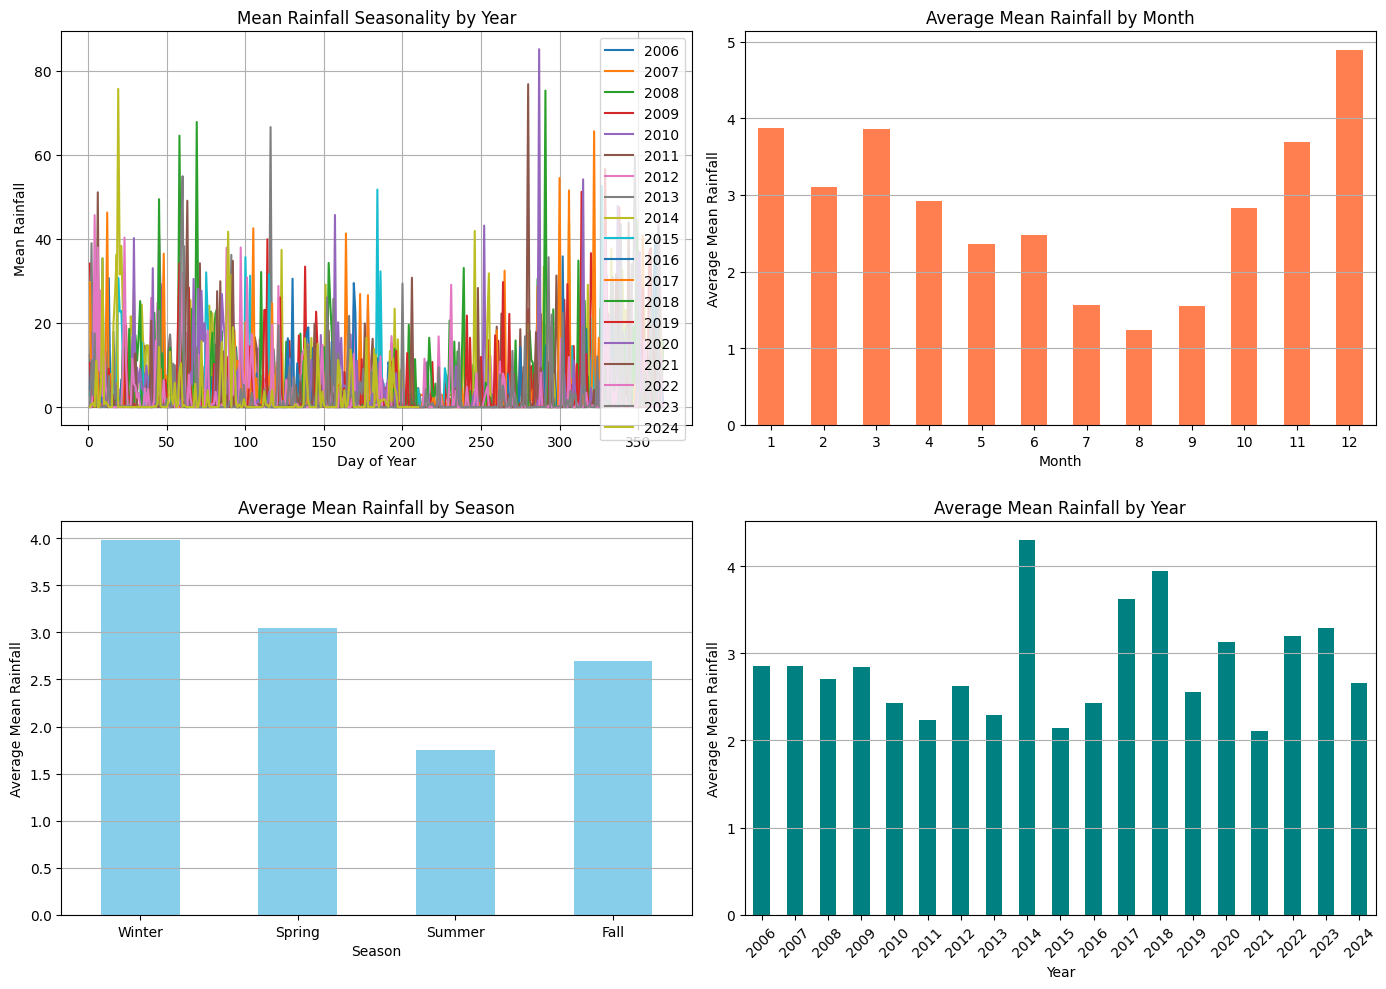

In [15]:
# Generate plots to explore Mean_Rainfall trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_rain = df.copy()

# Ensure 'Date' column is in datetime format
df_rain['Date'] = pd.to_datetime(df_rain['Date'])

# Plot 1: Mean_Rainfall across the year for each year
df_rain['year'] = df_rain['Date'].dt.year
df_rain['day_of_year'] = df_rain['Date'].dt.dayofyear

for year in df_rain['year'].unique():
    year_data = df_rain[df_rain['year'] == year]
    axes[0, 0].plot(year_data['day_of_year'], year_data['Mean_Rainfall'], label=str(year))

axes[0, 0].set_xlabel('Day of Year')
axes[0, 0].set_ylabel('Mean Rainfall')
axes[0, 0].set_title('Mean Rainfall Seasonality by Year')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Monthly average rainfall
df_rain['month'] = df_rain['Date'].dt.month
monthly_rain = df_rain.groupby('month')['Mean_Rainfall'].mean()
monthly_rain.plot(kind='bar', color='coral', ax=axes[0, 1])
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Mean Rainfall')
axes[0, 1].set_title('Average Mean Rainfall by Month')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(axis='y')

# Plot 3: Seasonal average rainfall
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_rain['Season'] = df_rain['Date'].apply(get_season)
seasonal_rain = df_rain.groupby('Season')['Mean_Rainfall'].mean()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_rain.reindex(season_order).plot(kind='bar', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Average Mean Rainfall')
axes[1, 0].set_title('Average Mean Rainfall by Season')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(axis='y')

# Plot 4: Yearly average rainfall
yearly_rain = df_rain.groupby('year')['Mean_Rainfall'].mean()
yearly_rain.plot(kind='bar', color='teal', ax=axes[1, 1])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Mean Rainfall')
axes[1, 1].set_title('Average Mean Rainfall by Year')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].grid(axis='y')

# Final layout adjustment
plt.tight_layout()
plt.show()


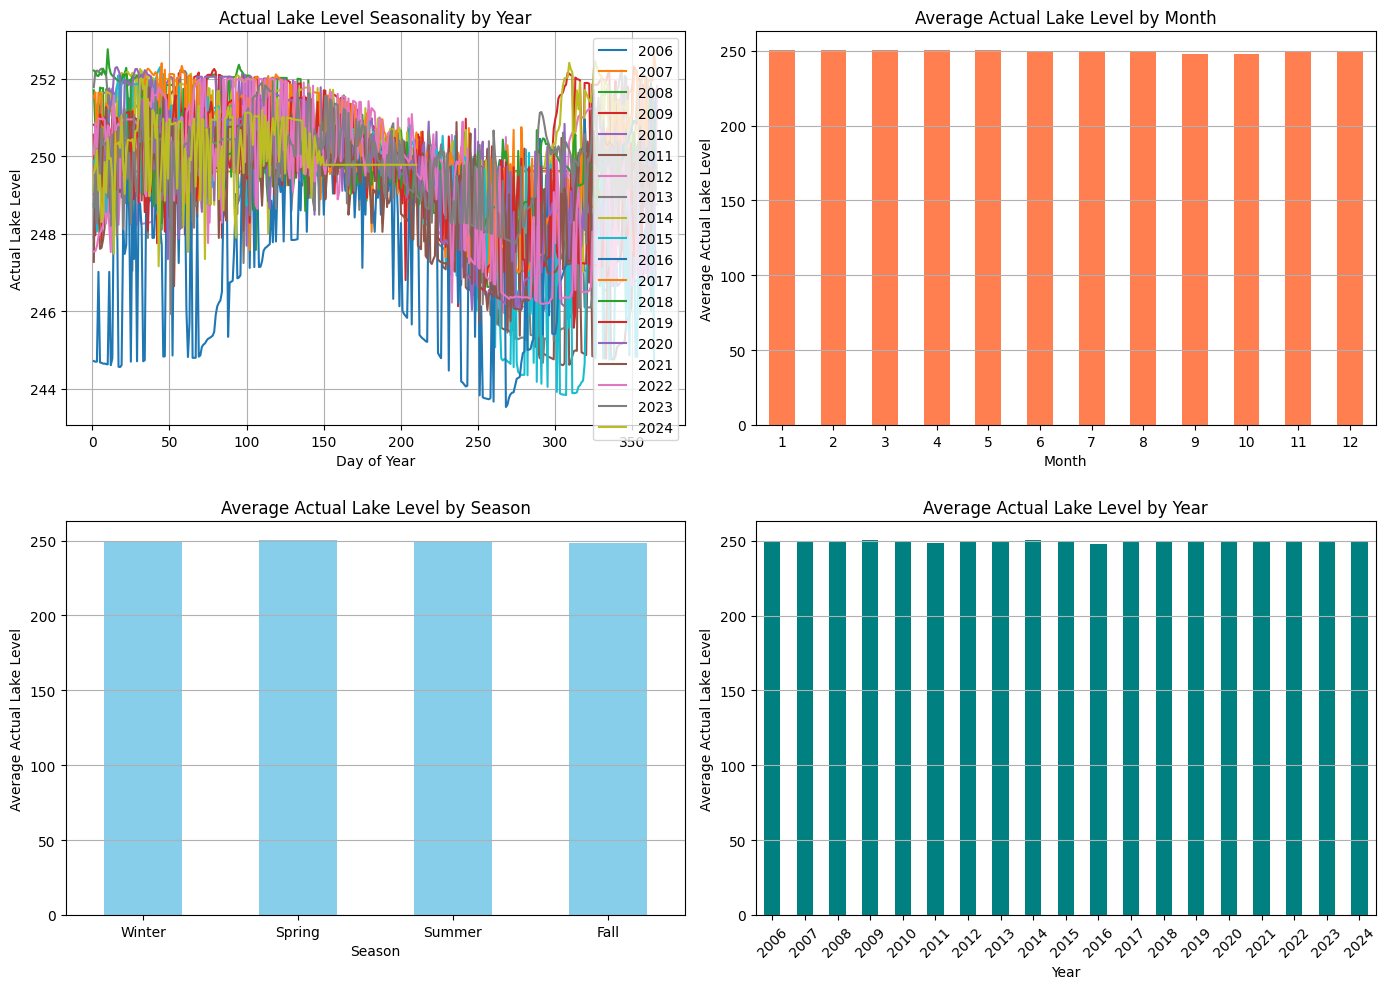

In [16]:
# Visualize Actual_Lake_Level trends with multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_lake = df.copy()

# Ensure 'Date' column is in datetime format
df_lake['Date'] = pd.to_datetime(df_lake['Date'])

# Plot 1: Yearly seasonal variation in Actual_Lake_Level
df_lake['year'] = df_lake['Date'].dt.year
df_lake['day_of_year'] = df_lake['Date'].dt.dayofyear

for year in df_lake['year'].unique():
    year_data = df_lake[df_lake['year'] == year]
    axes[0, 0].plot(year_data['day_of_year'], year_data['Actual_Lake_Level'], label=str(year))

axes[0, 0].set_xlabel('Day of Year')
axes[0, 0].set_ylabel('Actual Lake Level')
axes[0, 0].set_title('Actual Lake Level Seasonality by Year')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Monthly averages of lake level
df_lake['month'] = df_lake['Date'].dt.month
monthly_lake_level = df_lake.groupby('month')['Actual_Lake_Level'].mean()
monthly_lake_level.plot(kind='bar', color='coral', ax=axes[0, 1])
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Actual Lake Level')
axes[0, 1].set_title('Average Actual Lake Level by Month')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].grid(axis='y')

# Plot 3: Seasonal averages of lake level
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_lake['Season'] = df_lake['Date'].apply(get_season)
seasonal_lake_level = df_lake.groupby('Season')['Actual_Lake_Level'].mean()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_lake_level.reindex(season_order).plot(kind='bar', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Average Actual Lake Level')
axes[1, 0].set_title('Average Actual Lake Level by Season')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(axis='y')

# Plot 4: Yearly averages of lake level
yearly_lake_level = df_lake.groupby('year')['Actual_Lake_Level'].mean()
yearly_lake_level.plot(kind='bar', color='teal', ax=axes[1, 1])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Actual Lake Level')
axes[1, 1].set_title('Average Actual Lake Level by Year')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].grid(axis='y')

# Final layout adjustment
plt.tight_layout()
plt.show()


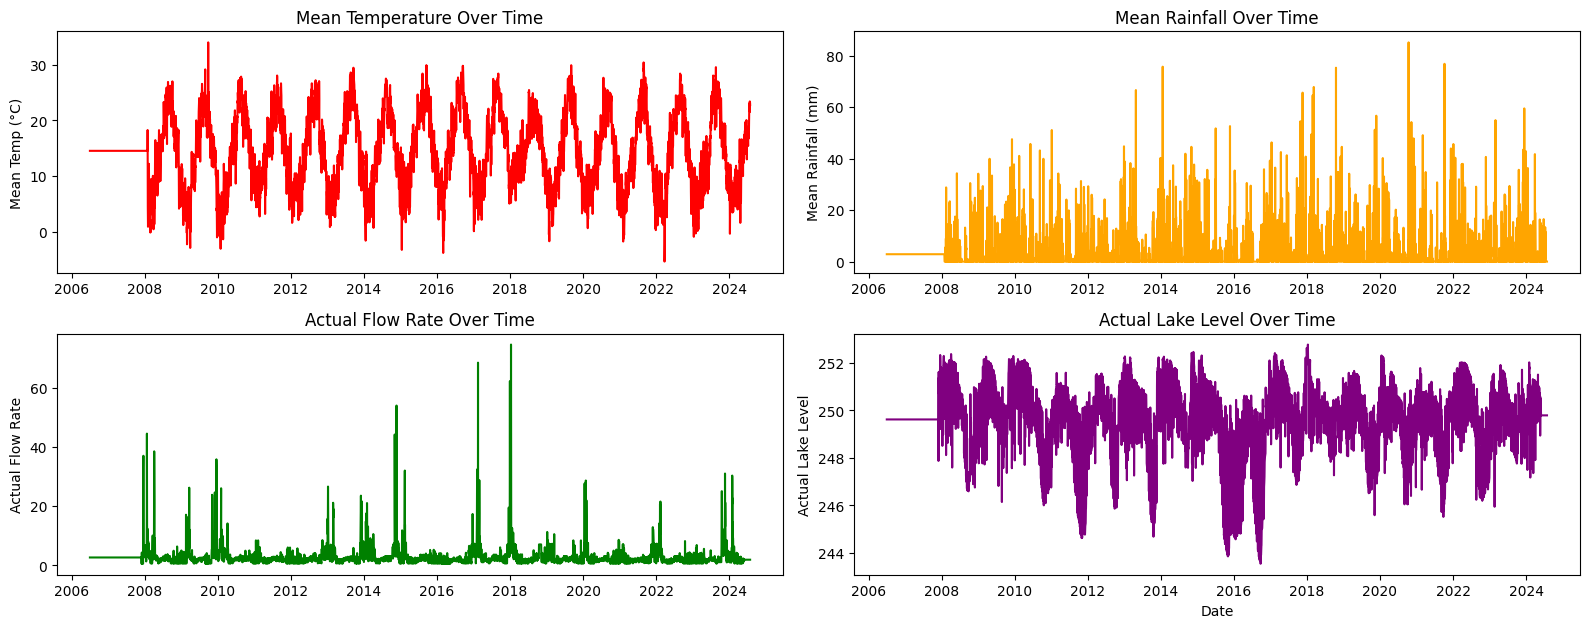

In [17]:
# Assuming df is your DataFrame with 'Date', 'Mean_Temp', 'Mean_Rainfall', 'Actual_Flow_Rate', and 'Actual_Lake_Level'
plt.figure(figsize=(16, 12))

plt.subplot(4, 2, 1)
plt.plot(df['Date'], df['Mean_Temp'], color='red')
plt.title('Mean Temperature Over Time')
plt.ylabel('Mean Temp (°C)')

plt.subplot(4, 2, 2)
plt.plot(df['Date'], df['Mean_Rainfall'], color='orange')
plt.title('Mean Rainfall Over Time')
plt.ylabel('Mean Rainfall (mm)')

plt.subplot(4, 2, 3)
plt.plot(df['Date'], df['Actual_Flow_Rate'], color='green')
plt.title('Actual Flow Rate Over Time')
plt.ylabel('Actual Flow Rate')

plt.subplot(4, 2, 4)
plt.plot(df['Date'], df['Actual_Lake_Level'], color='purple')
plt.title('Actual Lake Level Over Time')
plt.ylabel('Actual Lake Level')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

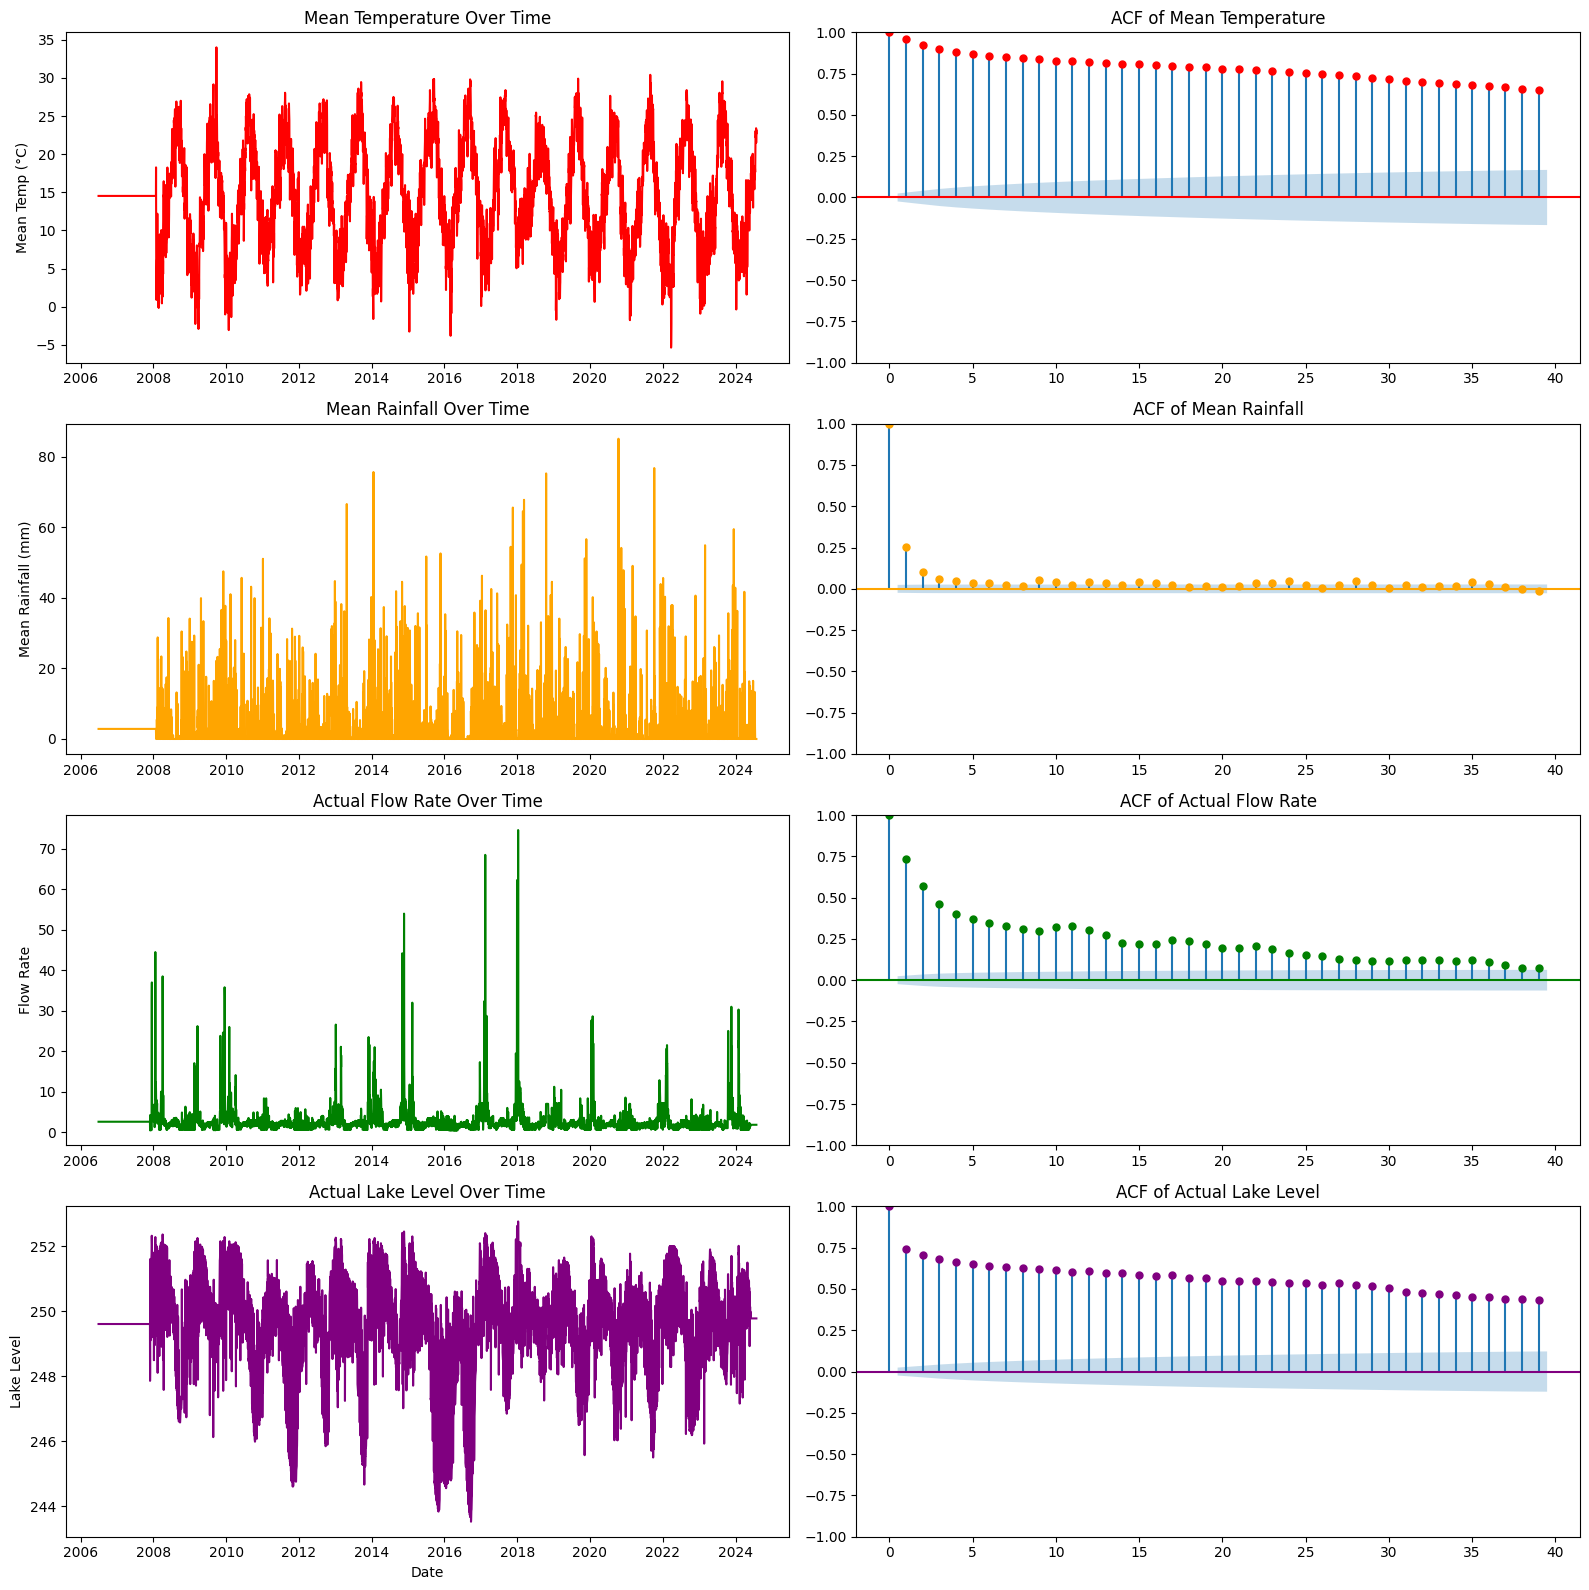

In [18]:
# Plot time series and ACFs for each variable with matching colors
plt.figure(figsize=(16, 16))

# Row 1: Mean Temperature
plt.subplot(4, 2, 1)
plt.plot(df['Date'], df['Mean_Temp'], color='red')
plt.title('Mean Temperature Over Time')
plt.ylabel('Mean Temp (°C)')

plt.subplot(4, 2, 2)
plot_acf(df['Mean_Temp'], ax=plt.gca(), color='red')
plt.title('ACF of Mean Temperature')

# Row 2: Mean Rainfall
plt.subplot(4, 2, 3)
plt.plot(df['Date'], df['Mean_Rainfall'], color='orange')
plt.title('Mean Rainfall Over Time')
plt.ylabel('Mean Rainfall (mm)')

plt.subplot(4, 2, 4)
plot_acf(df['Mean_Rainfall'], ax=plt.gca(), color='orange')
plt.title('ACF of Mean Rainfall')

# Row 3: Actual Flow Rate
plt.subplot(4, 2, 5)
plt.plot(df['Date'], df['Actual_Flow_Rate'], color='green')
plt.title('Actual Flow Rate Over Time')
plt.ylabel('Flow Rate')

plt.subplot(4, 2, 6)
plot_acf(df['Actual_Flow_Rate'], ax=plt.gca(), color='green')
plt.title('ACF of Actual Flow Rate')

# Row 4: Actual Lake Level
plt.subplot(4, 2, 7)
plt.plot(df['Date'], df['Actual_Lake_Level'], color='purple')
plt.title('Actual Lake Level Over Time')
plt.ylabel('Lake Level')
plt.xlabel('Date')

plt.subplot(4, 2, 8)
plot_acf(df['Actual_Lake_Level'], ax=plt.gca(), color='purple')
plt.title('ACF of Actual Lake Level')

plt.tight_layout()
plt.show()

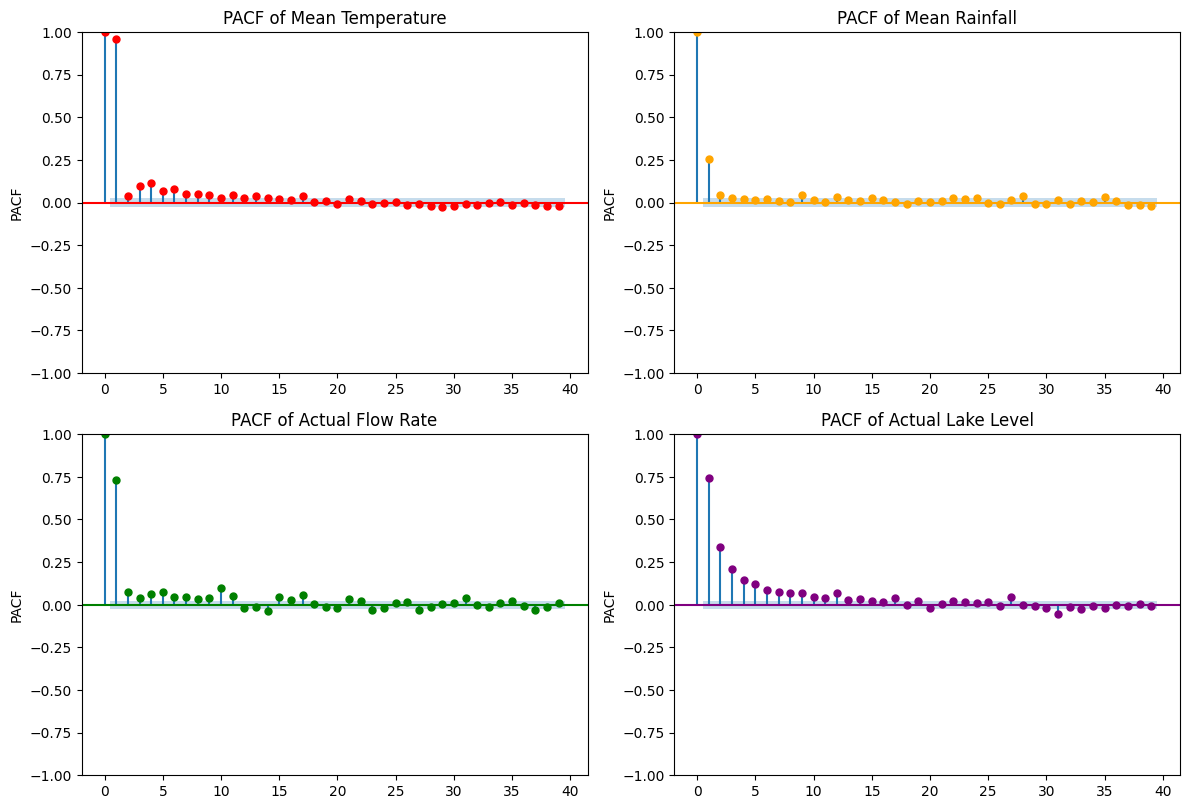

In [19]:
# Plot PACF for each time series
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plot_pacf(df['Mean_Temp'], ax=plt.gca(), color='red')
plt.title('PACF of Mean Temperature')
plt.ylabel('PACF')

plt.subplot(4, 2, 2)
plot_pacf(df['Mean_Rainfall'], ax=plt.gca(), color='orange')
plt.title('PACF of Mean Rainfall')
plt.ylabel('PACF')

plt.subplot(4, 2, 3)
plot_pacf(df['Actual_Flow_Rate'], ax=plt.gca(), color='green')
plt.title('PACF of Actual Flow Rate')
plt.ylabel('PACF')

plt.subplot(4, 2, 4)
plot_pacf(df['Actual_Lake_Level'], ax=plt.gca(), color='purple')
plt.title('PACF of Actual Lake Level')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()

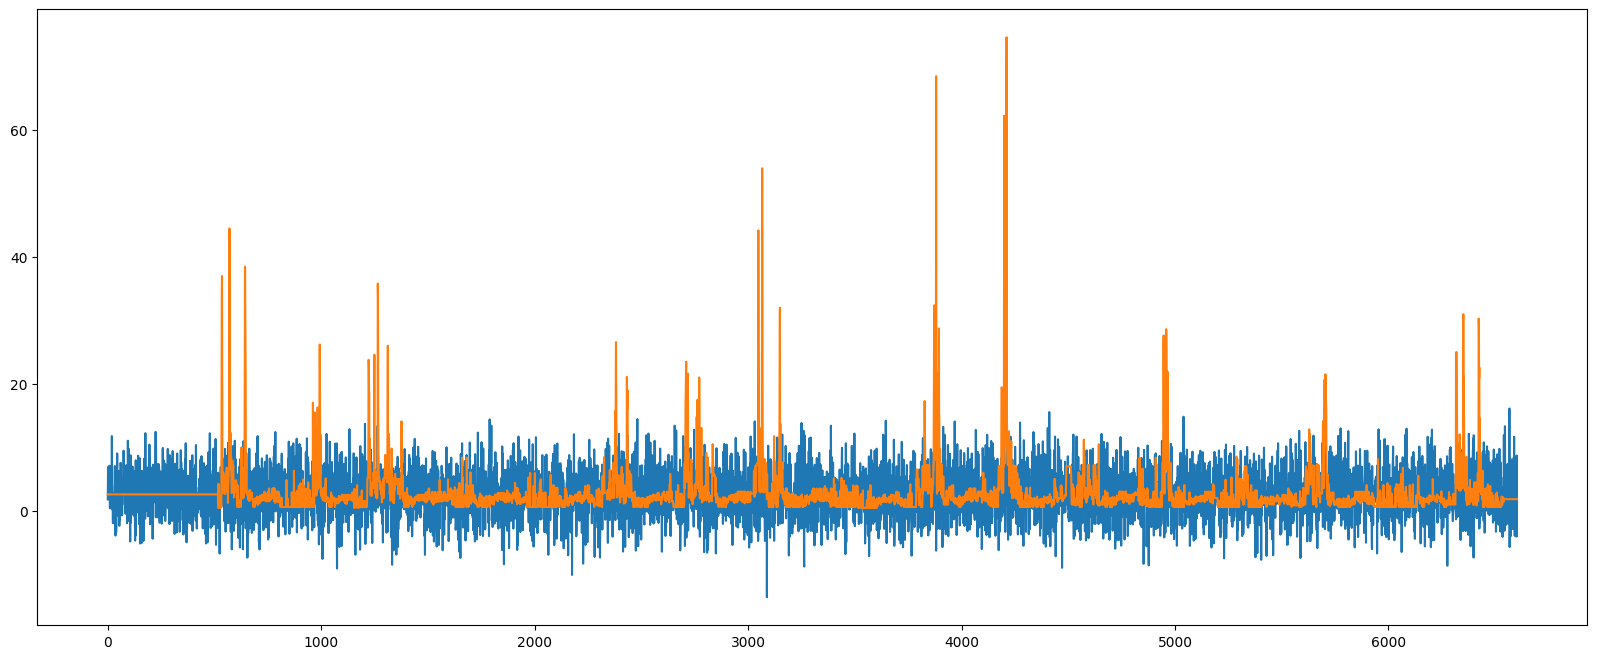

In [20]:
# checking with noise
dfw = df.copy()
wn = np.random.normal(loc = dfw.Actual_Flow_Rate.mean() , scale = dfw.Actual_Flow_Rate.std() , size = len(dfw))
dfw["wn"] = wn
dfw.describe()

plt.figure(figsize=(20,8))
plt.plot(dfw.wn)
plt.plot(dfw.Actual_Flow_Rate)

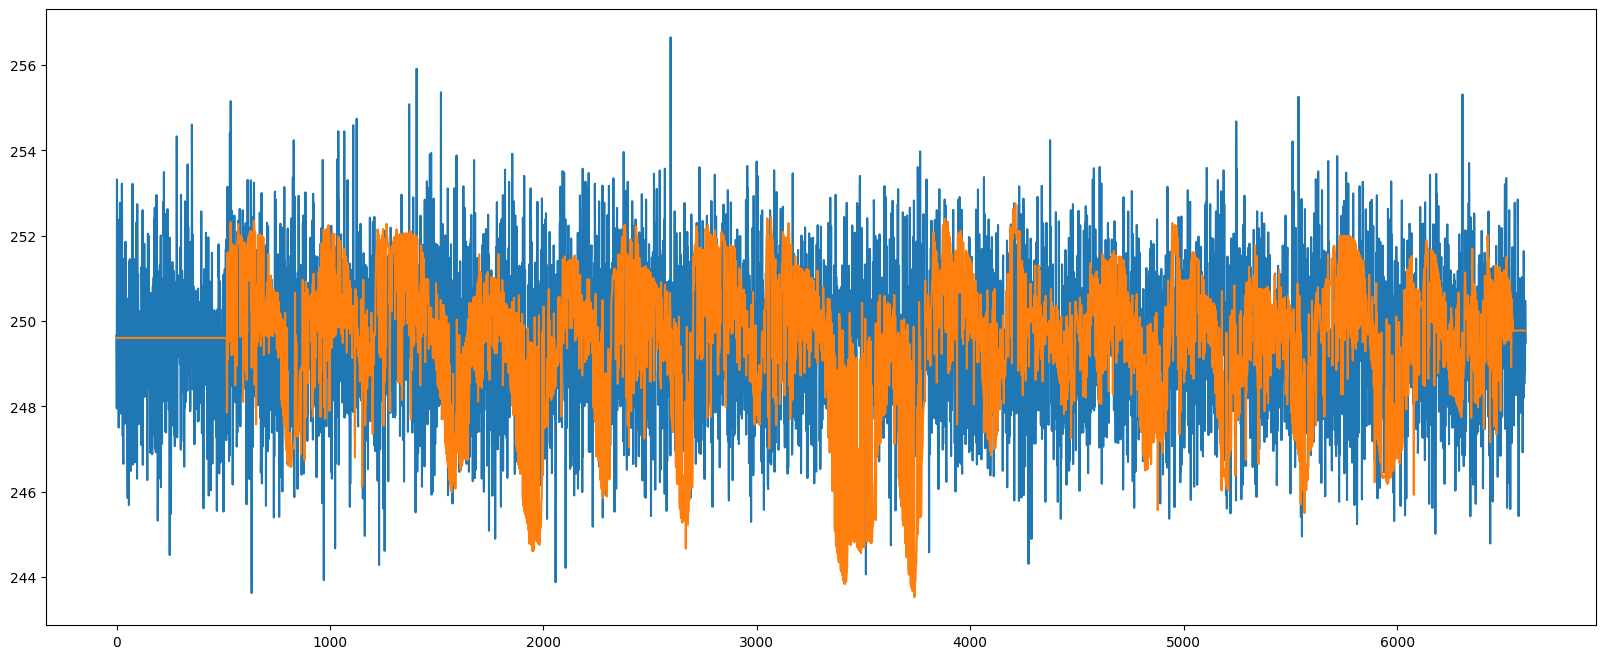

In [21]:
# checking with noise
dfl = df.copy()
wn = np.random.normal(loc = dfl.Actual_Lake_Level.mean() , scale = dfl.Actual_Lake_Level.std() , size = len(dfl))
dfl["wn"] = wn
dfl.describe()

plt.figure(figsize=(20,8))
plt.plot(dfl.wn)
plt.plot(dfl.Actual_Lake_Level)

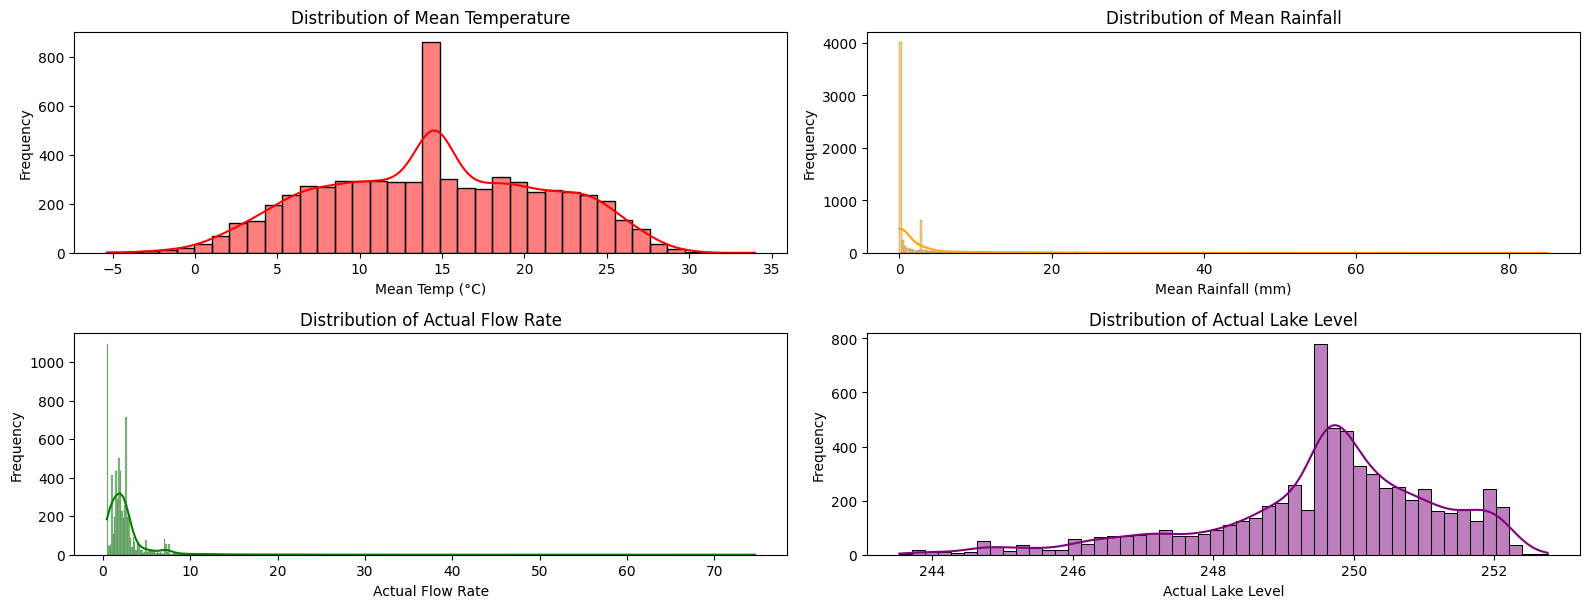

In [22]:
# Assuming df is your DataFrame with 'Date', 'Mean_Temp', 'Mean_Rainfall', 'Actual_Flow_Rate', and 'Actual_Lake_Level'
plt.figure(figsize=(16, 12))

plt.subplot(4, 2, 5)
sns.histplot(df['Mean_Temp'], kde=True, color='red', ax=plt.gca())
plt.title('Distribution of Mean Temperature')
plt.xlabel('Mean Temp (°C)')
plt.ylabel('Frequency')

plt.subplot(4, 2, 6)
sns.histplot(df['Mean_Rainfall'], kde=True, color='orange', ax=plt.gca())
plt.title('Distribution of Mean Rainfall')
plt.xlabel('Mean Rainfall (mm)')
plt.ylabel('Frequency')

plt.subplot(4, 2, 7)
sns.histplot(df['Actual_Flow_Rate'], kde=True, color='green', ax=plt.gca())
plt.title('Distribution of Actual Flow Rate')
plt.xlabel('Actual Flow Rate')
plt.ylabel('Frequency')

plt.subplot(4, 2, 8)
sns.histplot(df['Actual_Lake_Level'], kde=True, color='purple', ax=plt.gca())
plt.title('Distribution of Actual Lake Level')
plt.xlabel('Actual Lake Level')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

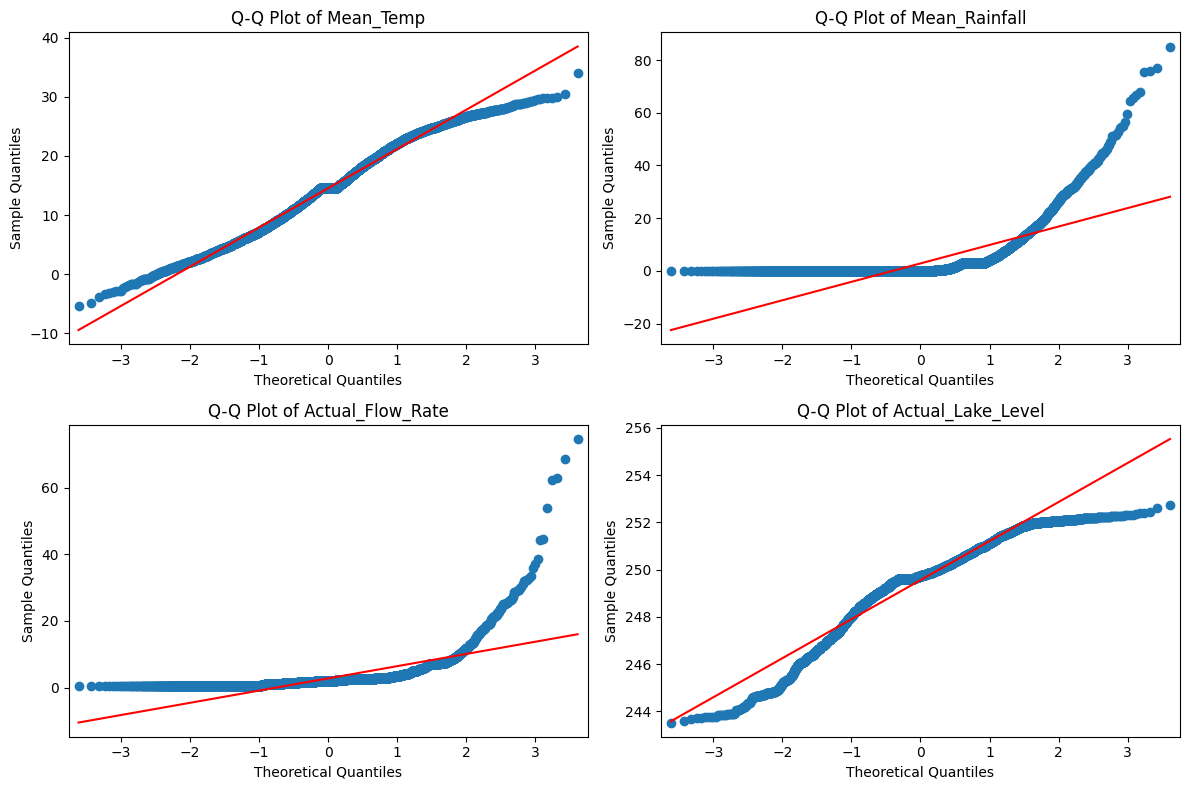

In [23]:
# Define the columns to create Q-Q plots for
columns_to_qqplot = ['Mean_Temp', 'Mean_Rainfall', 'Actual_Flow_Rate', 'Actual_Lake_Level']

# Create Q-Q plots for each column
plt.figure(figsize=(12, 8))

for i, col in enumerate(columns_to_qqplot):
    plt.subplot(2, 2, i + 1)
    qqplot(df[col], line='s', ax=plt.gca()) # line='s' plots a standard line
    plt.title(f'Q-Q Plot of {col}')

plt.tight_layout()
plt.show()

In [24]:
# Define the columns to test for normality
columns_to_test = ['Mean_Temp', 'Mean_Rainfall', 'Actual_Flow_Rate', 'Actual_Lake_Level']

# Perform the Kolmogorov-Smirnov test for each column
for col in columns_to_test:
    # Extract the data for the current column
    data = df[col].dropna() # Handle potential NaN values

    # Perform the K-S test against a normal distribution
    # The 'norm' argument specifies that we are testing against a normal distribution.
    # The 'args=(data.mean(), data.std())' provides the mean and standard deviation
    # of the data to the normal distribution function.
    ks_statistic, p_value = kstest(data, 'norm', args=(data.mean(), data.std()))

    # Print the results
    print(f"Kolmogorov-Smirnov test for {col}:")
    print(f"  KS Statistic: {ks_statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")

    # Interpret the p-value (assuming significance level alpha = 0.05)
    if p_value < 0.05:
        print(f"  Reject the null hypothesis: The data for {col} is likely NOT normally distributed.")
    else:
        print(f"  Fail to reject the null hypothesis: The data for {col} might be normally distributed.")
    print("-" * 30)


Kolmogorov-Smirnov test for Mean_Temp:
  KS Statistic: 0.0453
  P-value: 0.0000
  Reject the null hypothesis: The data for Mean_Temp is likely NOT normally distributed.
------------------------------
Kolmogorov-Smirnov test for Mean_Rainfall:
  KS Statistic: 0.3415
  P-value: 0.0000
  Reject the null hypothesis: The data for Mean_Rainfall is likely NOT normally distributed.
------------------------------
Kolmogorov-Smirnov test for Actual_Flow_Rate:
  KS Statistic: 0.2833
  P-value: 0.0000
  Reject the null hypothesis: The data for Actual_Flow_Rate is likely NOT normally distributed.
------------------------------
Kolmogorov-Smirnov test for Actual_Lake_Level:
  KS Statistic: 0.1348
  P-value: 0.0000
  Reject the null hypothesis: The data for Actual_Lake_Level is likely NOT normally distributed.
------------------------------


In [25]:
flow_rate = df['Actual_Flow_Rate']

# Augmented Dickey-Fuller (ADF) Test
print("--- ADF Test ---")
adf_result = adfuller(flow_rate)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Lags used:", adf_result[2])
print("Number of observations:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)

# KPSS Test
print("--- KPSS Test ---")
kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(flow_rate, regression='c', nlags='auto')
print("KPSS Statistic:", kpss_stat)
print("p-value:", kpss_p_value)
print("Lags used:", kpss_lags)
print("Critical Values:")
for key, value in kpss_crit.items():
    print(f"   {key}: {value}")

if kpss_p_value < 0.05:
    print("\nConclusion: The series is likely non-stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely stationary (fail to reject the null hypothesis).")
print("-" * 40)

# Phillips-Perron Test
print("--- Phillips-Perron Test ---")
pp_test = PhillipsPerron(flow_rate)
print("PP Statistic:", pp_test.stat)
print("p-value:", pp_test.pvalue)
print("Lags used:", pp_test.lags)
print("Trend type:", pp_test.trend)

if pp_test.pvalue < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)


--- ADF Test ---
ADF Statistic: -9.791564517287616
p-value: 6.333247220716143e-17
Lags used: 30
Number of observations: 6572
Critical Values:
   1%: -3.431345413269675
   5%: -2.861979888188583
   10%: -2.567004149029117

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------
--- KPSS Test ---
KPSS Statistic: 0.08477613540529906
p-value: 0.1
Lags used: 44
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Conclusion: The series is likely stationary (fail to reject the null hypothesis).
----------------------------------------
--- Phillips-Perron Test ---
PP Statistic: -41.54750378727643
p-value: 0.0
Lags used: 35
Trend type: c

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------


/tmp/ipython-input-25-2844365840.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(flow_rate, regression='c', nlags='auto')


In [26]:
lake_level = df['Actual_Lake_Level']

# Augmented Dickey-Fuller (ADF) Test
print("--- ADF Test ---")
adf_result = adfuller(lake_level)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Lags used:", adf_result[2])
print("Number of observations:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)

# KPSS Test
print("--- KPSS Test ---")
kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(lake_level, regression='c', nlags='auto')
print("KPSS Statistic:", kpss_stat)
print("p-value:", kpss_p_value)
print("Lags used:", kpss_lags)
print("Critical Values:")
for key, value in kpss_crit.items():
    print(f"   {key}: {value}")

if kpss_p_value < 0.05:
    print("\nConclusion: The series is likely non-stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely stationary (fail to reject the null hypothesis).")
print("-" * 40)

# Phillips-Perron (PP) Test
print("--- Phillips-Perron Test ---")
pp_test = PhillipsPerron(lake_level)
print("PP Statistic:", pp_test.stat)
print("p-value:", pp_test.pvalue)
print("Lags used:", pp_test.lags)
print("Trend type:", pp_test.trend)

if pp_test.pvalue < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)


--- ADF Test ---
ADF Statistic: -5.966715241149874
p-value: 1.9798094171562556e-07
Lags used: 32
Number of observations: 6570
Critical Values:
   1%: -3.4313457164059282
   5%: -2.861980022126644
   10%: -2.567004220327164

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------
--- KPSS Test ---
KPSS Statistic: 0.1400003034444549
p-value: 0.1
Lags used: 49
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Conclusion: The series is likely stationary (fail to reject the null hypothesis).
----------------------------------------
--- Phillips-Perron Test ---
PP Statistic: -51.78118754820957
p-value: 0.0
Lags used: 35
Trend type: c

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------


/tmp/ipython-input-26-1077983707.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(lake_level, regression='c', nlags='auto')


In [27]:
mean_temp = df['Mean_Temp']

# Augmented Dickey-Fuller (ADF) Test
print("--- ADF Test ---")
adf_result = adfuller(mean_temp)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Lags used:", adf_result[2])
print("Number of observations:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)

# KPSS Test
print("--- KPSS Test ---")
kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(mean_temp, regression='c', nlags='auto')
print("KPSS Statistic:", kpss_stat)
print("p-value:", kpss_p_value)
print("Lags used:", kpss_lags)
print("Critical Values:")
for key, value in kpss_crit.items():
    print(f"   {key}: {value}")

if kpss_p_value < 0.05:
    print("\nConclusion: The series is likely non-stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely stationary (fail to reject the null hypothesis).")
print("-" * 40)

# Phillips-Perron Test
print("--- Phillips-Perron Test ---")
pp_test = PhillipsPerron(mean_temp)
print("PP Statistic:", pp_test.stat)
print("p-value:", pp_test.pvalue)
print("Lags used:", pp_test.lags)
print("Trend type:", pp_test.trend)

if pp_test.pvalue < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)


--- ADF Test ---
ADF Statistic: -4.785258593472906
p-value: 5.802957682407178e-05
Lags used: 16
Number of observations: 6586
Critical Values:
   1%: -3.431343296472979
   5%: -2.8619789529003854
   10%: -2.5670036511556

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------
--- KPSS Test ---
KPSS Statistic: 0.03739958472849347
p-value: 0.1
Lags used: 50
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Conclusion: The series is likely stationary (fail to reject the null hypothesis).
----------------------------------------
--- Phillips-Perron Test ---
PP Statistic: -10.464892821927943
p-value: 1.3295752303385695e-18
Lags used: 35
Trend type: c

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------


/tmp/ipython-input-27-2207087871.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(mean_temp, regression='c', nlags='auto')


In [28]:
mean_rainfall = df['Mean_Rainfall']

# Augmented Dickey-Fuller (ADF) Test
print("--- ADF Test ---")
adf_result = adfuller(mean_rainfall)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Lags used:", adf_result[2])
print("Number of observations:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)

# KPSS Test
print("--- KPSS Test ---")
kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(mean_rainfall, regression='c', nlags='auto')
print("KPSS Statistic:", kpss_stat)
print("p-value:", kpss_p_value)
print("Lags used:", kpss_lags)
print("Critical Values:")
for key, value in kpss_crit.items():
    print(f"   {key}: {value}")

if kpss_p_value < 0.05:
    print("\nConclusion: The series is likely non-stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely stationary (fail to reject the null hypothesis).")
print("-" * 40)

# Phillips-Perron (PP) Test
print("--- Phillips-Perron Test ---")
pp_test = PhillipsPerron(mean_rainfall)
print("PP Statistic:", pp_test.stat)
print("p-value:", pp_test.pvalue)
print("Lags used:", pp_test.lags)
print("Trend type:", pp_test.trend)

if pp_test.pvalue < 0.05:
    print("\nConclusion: The series is likely stationary (reject the null hypothesis).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject the null hypothesis).")
print("-" * 40)


--- ADF Test ---
ADF Statistic: -17.493390316112087
p-value: 4.424573779893539e-30
Lags used: 14
Number of observations: 6588
Critical Values:
   1%: -3.431342994808163
   5%: -2.8619788196123577
   10%: -2.5670035802035973

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------
--- KPSS Test ---
KPSS Statistic: 0.12887071155074045
p-value: 0.1
Lags used: 25
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Conclusion: The series is likely stationary (fail to reject the null hypothesis).
----------------------------------------
--- Phillips-Perron Test ---
PP Statistic: -68.33009054680926
p-value: 0.0
Lags used: 35
Trend type: c

Conclusion: The series is likely stationary (reject the null hypothesis).
----------------------------------------


/tmp/ipython-input-28-1535011535.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p_value, kpss_lags, kpss_crit = kpss(mean_rainfall, regression='c', nlags='auto')


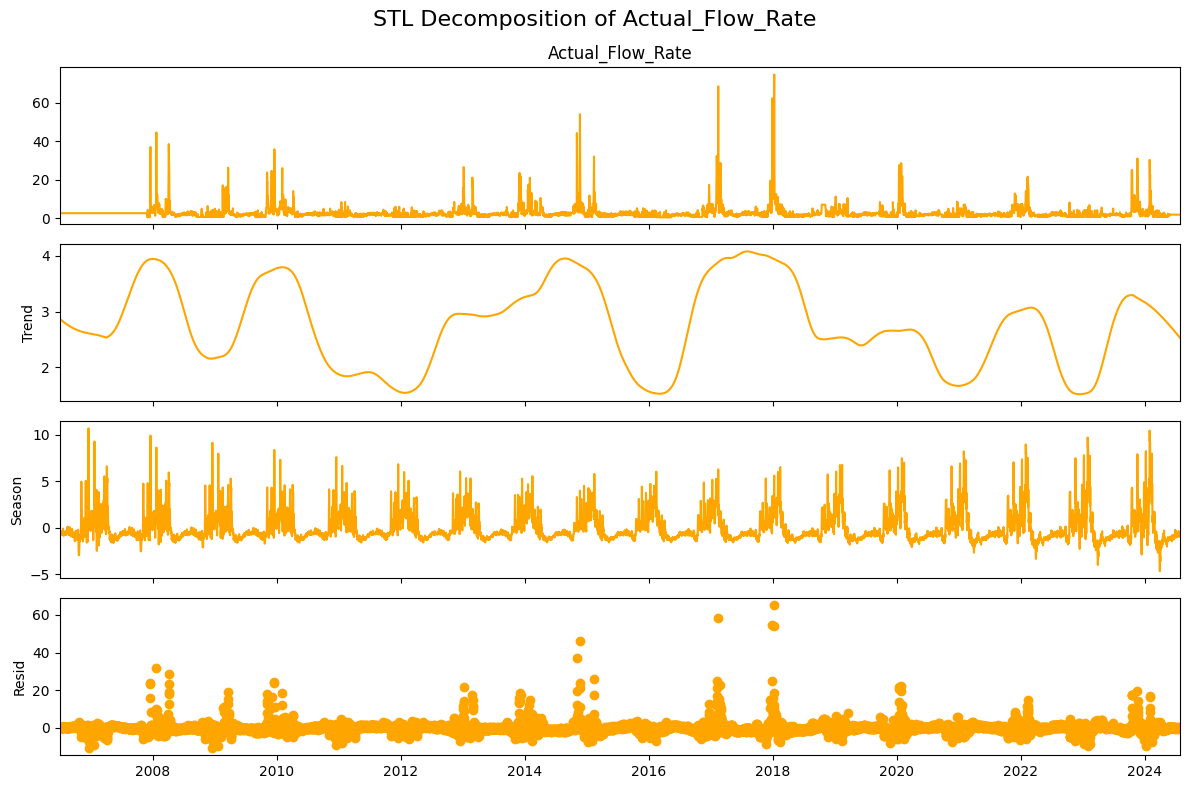

In [29]:
# Make a temporary copy and set index just for STL
df_temp = df.copy()
df_temp = df_temp.set_index('Date')

# Apply STL
from statsmodels.tsa.seasonal import STL


series = df_temp['Actual_Flow_Rate']
stl = STL(series, period=365, seasonal=365, robust=False)
result = stl.fit()

# Plot with orange color
fig = result.plot()

# Change the color of all plots to orange
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('orange')

fig.set_size_inches(12, 8)
plt.suptitle('STL Decomposition of Actual_Flow_Rate', fontsize=16)
plt.tight_layout()
plt.show()


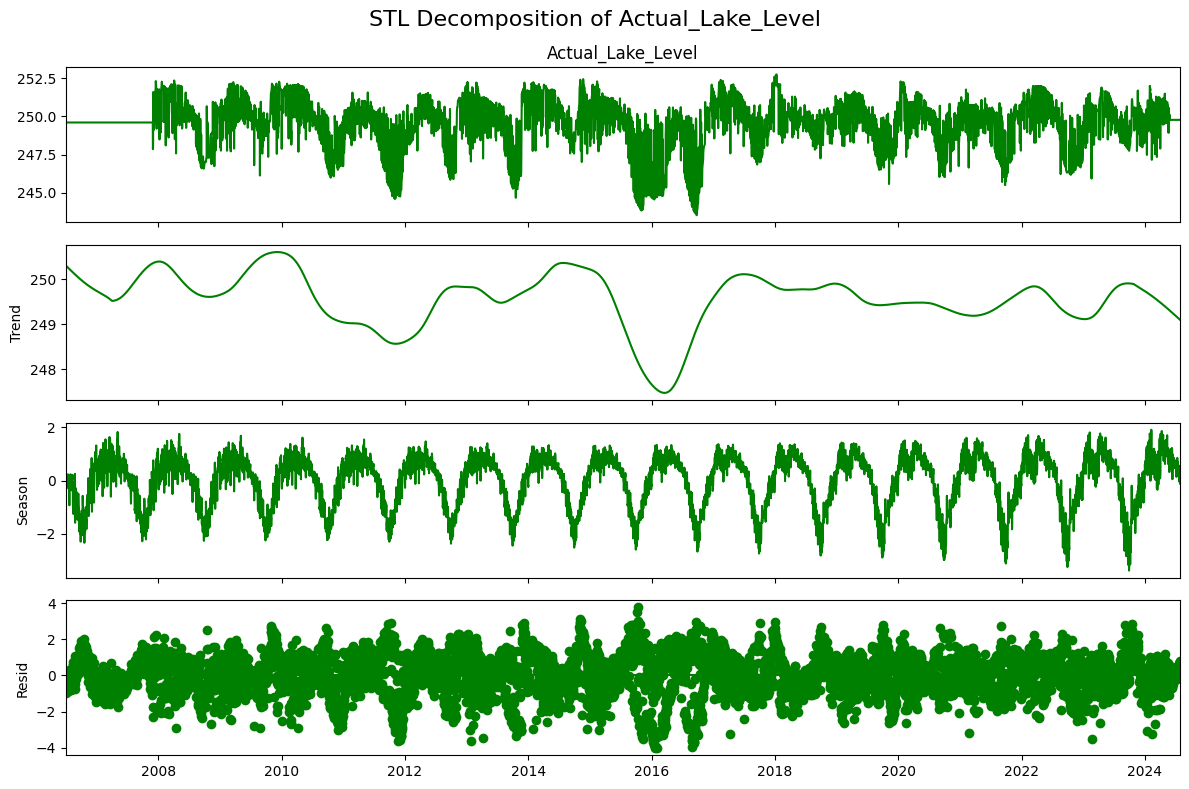

In [30]:
# Make a temporary copy and set index just for STL
df_temp = df.copy()
df_temp = df_temp.set_index('Date')

# Apply STL

series = df_temp['Actual_Lake_Level']
stl = STL(series, period=365, seasonal=365, robust=False)
result = stl.fit()

# Plot with orange color
fig = result.plot()

# Change the color of all plots to orange
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('green')

fig.set_size_inches(12, 8)
plt.suptitle('STL Decomposition of Actual_Lake_Level', fontsize=16)
plt.tight_layout()
plt.show()


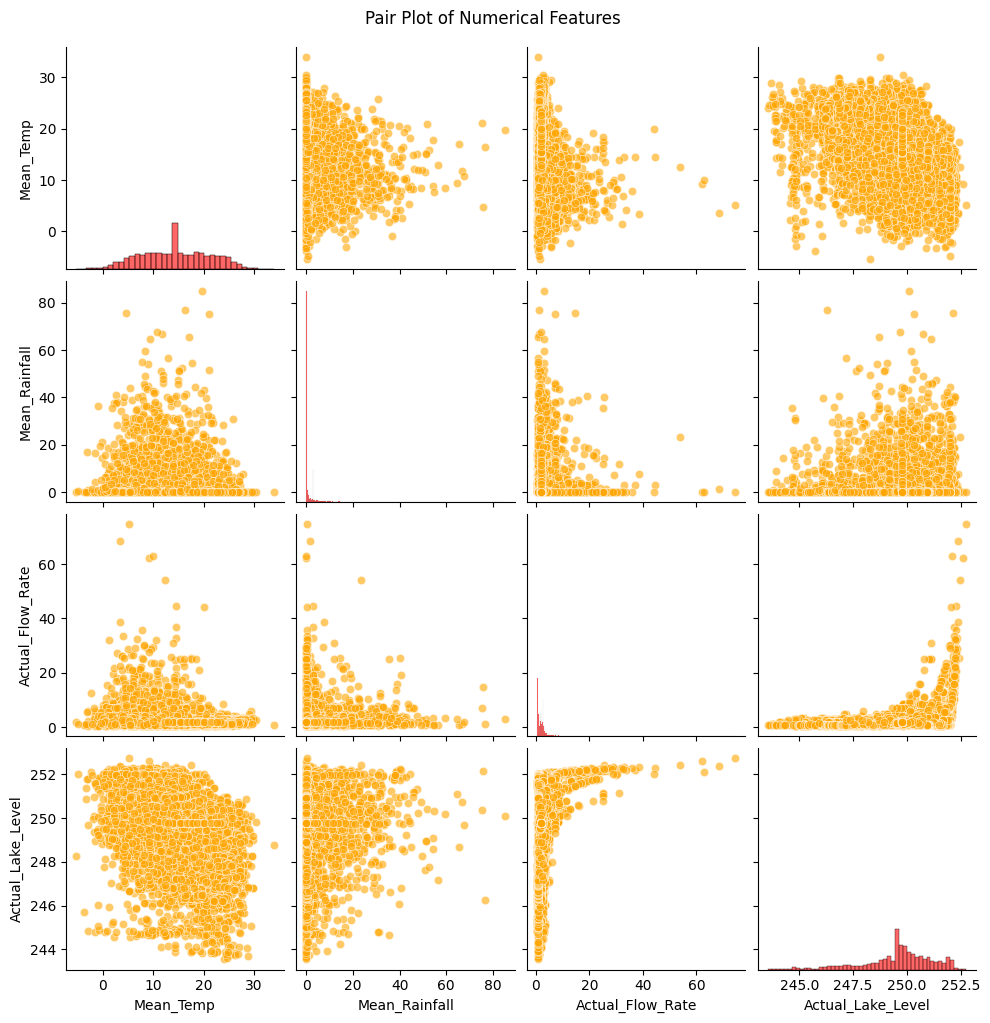

In [31]:
# Select only the numerical columns for the pair plot
numerical_cols = ['Mean_Temp', 'Mean_Rainfall', 'Actual_Flow_Rate', 'Actual_Lake_Level']
df_numerical = df[numerical_cols]


# Define the colors
scatter_color = 'orange'
hist_color = 'red'

# Create the pair plot
sns.pairplot(df_numerical,
             plot_kws={'color': scatter_color, 'alpha': 0.6},  # Scatter plot properties
             diag_kws={'color': hist_color, 'alpha': 0.6})     # Histogram properties

plt.suptitle('Pair Plot of Numerical Features', y=1.02) # Add a title
plt.show()


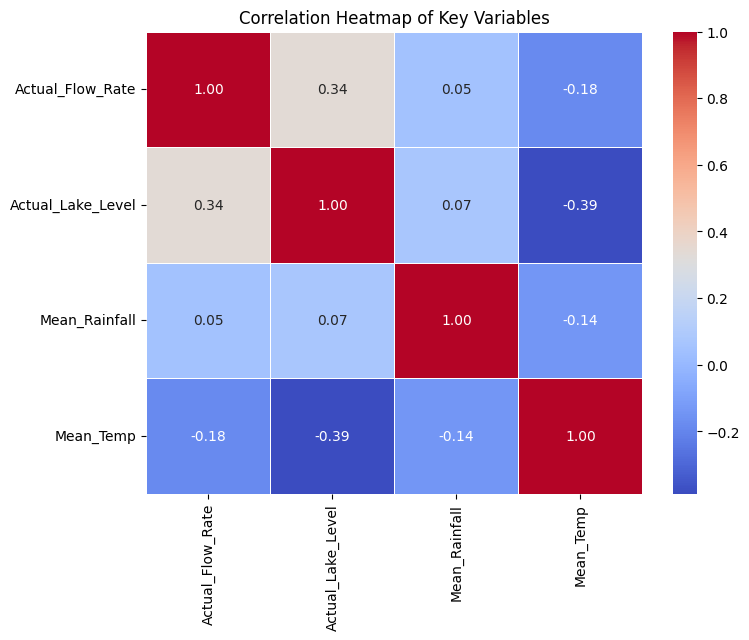

In [32]:
# Select the columns for the heatmap
correlation_columns = ['Actual_Flow_Rate', 'Actual_Lake_Level', 'Mean_Rainfall', 'Mean_Temp']
df_corr = df[correlation_columns]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Key Variables')
plt.show()

# **Pre processing**

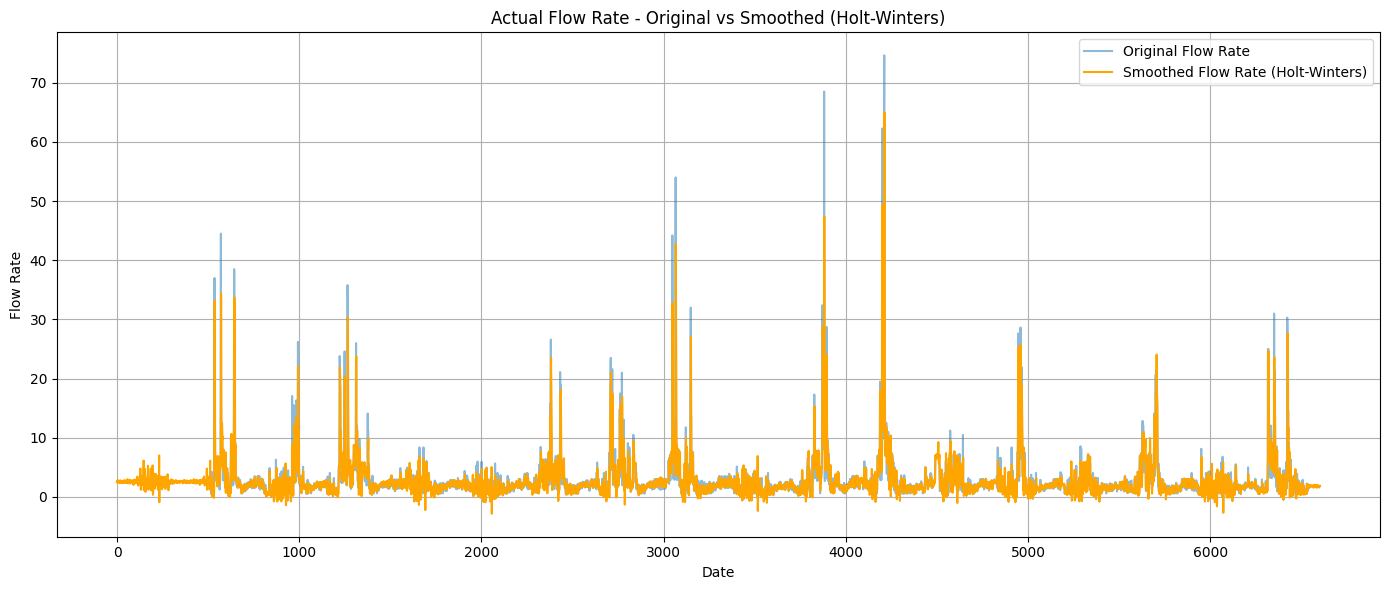

In [33]:
df_flow = df.copy()
# Select the column for smoothing
series = df_flow['Actual_Flow_Rate']

# Apply Holt-Winters Exponential Smoothing
model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=365)
fit_model = model.fit()

# Add smoothed series to the DataFrame (optional)
df_flow['Smoothed_Flow'] = fit_model.fittedvalues

# Plot the original and smoothed series
plt.figure(figsize=(14, 6))
plt.plot(series, label='Original Flow Rate', alpha=0.5)
plt.plot(df_flow['Smoothed_Flow'], label='Smoothed Flow Rate (Holt-Winters)', color='orange')
plt.title("Actual Flow Rate - Original vs Smoothed (Holt-Winters)")
plt.xlabel("Date")
plt.ylabel("Flow Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
df_flow = df_flow.drop(columns=['Actual_Flow_Rate'])
df_flow.head()

Date  Mean_Rainfall  Mean_Temp  Actual_Lake_Level  Smoothed_Flow
0 2006-07-01       2.857312  14.530141         249.606745       2.499118
1 2006-07-02       2.857312  14.530141         249.606745       2.535799
2 2006-07-03       2.857312  14.530141         249.606745       2.723050
3 2006-07-04       2.857312  14.530141         249.606745       2.772444
4 2006-07-05       2.857312  14.530141         249.606745       2.398411

In [35]:
df_flow_flow = df_flow.copy()
# Define features (X) and target (y)
# Assuming all columns except the target are features
X = df_flow_flow.drop('Smoothed_Flow', axis=1)
y = df_flow_flow['Smoothed_Flow']

# Split the data into training and testing sets
x_train_flow, x_test_flow, y_train_flow, y_test_flow = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print the shapes of the resulting datasets to verify the split
print("Shape of X_train:", x_train_flow.shape)
print("Shape of X_test:", x_test_flow.shape)
print("Shape of y_train:", y_train_flow.shape)
print("Shape of y_test:", y_test_flow.shape)

# Display the first few rows of the training and testing sets (optional)
print("\nX_train head:")
print(x_train_flow.head())

print("\nX_test head:")
print(x_test_flow.head())

print("\ny_train head:")
print(y_train_flow.head())

print("\ny_test head:")
print(y_test_flow.head())

Shape of X_train: (5282, 4)
Shape of X_test: (1321, 4)
Shape of y_train: (5282,)
Shape of y_test: (1321,)

X_train head:
        Date  Mean_Rainfall  Mean_Temp  Actual_Lake_Level
0 2006-07-01       2.857312  14.530141         249.606745
1 2006-07-02       2.857312  14.530141         249.606745
2 2006-07-03       2.857312  14.530141         249.606745
3 2006-07-04       2.857312  14.530141         249.606745
4 2006-07-05       2.857312  14.530141         249.606745

X_test head:
           Date  Mean_Rainfall  Mean_Temp  Actual_Lake_Level
5282 2020-12-16          36.88      10.90         248.720000
5283 2020-12-17           1.32      12.55         250.116667
5284 2020-12-18           1.40      13.15         248.845000
5285 2020-12-19           0.00      13.20         249.392500
5286 2020-12-20           0.00      13.65         248.740000

y_train head:
0    2.499118
1    2.535799
2    2.723050
3    2.772444
4    2.398411
Name: Smoothed_Flow, dtype: float64

y_test head:
5282   -0.764828

In [36]:
# Define the columns to scale
columns_to_scale = ['Mean_Rainfall', 'Mean_Temp', 'Actual_Lake_Level']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
# Only fit on the training data to avoid data leakage from the test set
x_train_flow[columns_to_scale] = scaler.fit_transform(x_train_flow[columns_to_scale])
x_test_flow[columns_to_scale] = scaler.transform(x_test_flow[columns_to_scale])

# Print the first few rows of the scaled data to verify (optional)
print("\nX_train after scaling:")
print(x_train_flow.head())

print("\nX_test after scaling:")
print(x_test_flow.head())


X_train after scaling:
        Date  Mean_Rainfall  Mean_Temp  Actual_Lake_Level
0 2006-07-01      -0.000801  -0.031558           0.036223
1 2006-07-02      -0.000801  -0.031558           0.036223
2 2006-07-03      -0.000801  -0.031558           0.036223
3 2006-07-04      -0.000801  -0.031558           0.036223
4 2006-07-05      -0.000801  -0.031558           0.036223

X_test after scaling:
           Date  Mean_Rainfall  Mean_Temp  Actual_Lake_Level
5282 2020-12-16       4.931651  -0.590545          -0.482895
5283 2020-12-17      -0.223673  -0.336470           0.334741
5284 2020-12-18      -0.212075  -0.244079          -0.409718
5285 2020-12-19      -0.415041  -0.236380          -0.089200
5286 2020-12-20      -0.415041  -0.167086          -0.471187


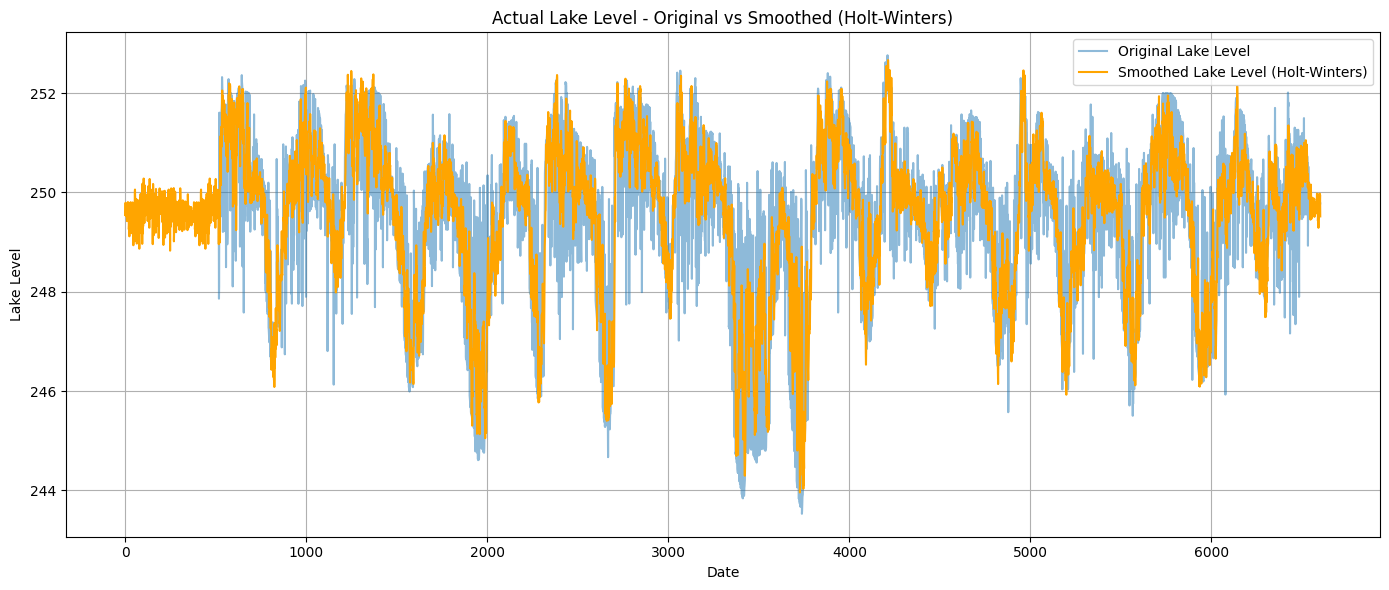

In [37]:
# Assuming df is your time series data
df_lake = df.copy()

# Select the Actual_Lake_Level column for smoothing
series = df_lake['Actual_Lake_Level']

# Apply Holt-Winters Exponential Smoothing with trend and seasonality
model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=365)
fit_model = model.fit()

# Add smoothed series to the DataFrame (optional)
df_lake['Smoothed_Lake_Level'] = fit_model.fittedvalues

# Plot the original and smoothed series
plt.figure(figsize=(14, 6))
plt.plot(series, label='Original Lake Level', alpha=0.5)
plt.plot(df_lake['Smoothed_Lake_Level'], label='Smoothed Lake Level (Holt-Winters)', color='orange')
plt.title("Actual Lake Level - Original vs Smoothed (Holt-Winters)")
plt.xlabel("Date")
plt.ylabel("Lake Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
df_lake.drop(columns=['Actual_Lake_Level'], inplace=True)
df_lake.head()

Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate  Smoothed_Lake_Level
0 2006-07-01       2.857312  14.530141          2.578255           249.546889
1 2006-07-02       2.857312  14.530141          2.578255           249.791242
2 2006-07-03       2.857312  14.530141          2.578255           249.528936
3 2006-07-04       2.857312  14.530141          2.578255           249.589548
4 2006-07-05       2.857312  14.530141          2.578255           249.688248

In [39]:
df_lake_lake = df_lake.copy()
# Assuming df_lake contains the original data and Smoothed_Lake_Level is the target column
# Define features (X) and target (y)
X = df_lake_lake.drop('Smoothed_Lake_Level', axis=1)  # All columns except the target
y = df_lake_lake['Smoothed_Lake_Level']  # Smoothed_Lake_Level as target

# Split the data into training and testing sets (80% train, 20% test)
x_train_level, x_test_level, y_train_level, y_test_level = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print the shapes of the resulting datasets to verify the split
print("Shape of X_train:", x_train_level.shape)
print("Shape of X_test:", x_test_level.shape)
print("Shape of y_train:", y_train_level.shape)
print("Shape of y_test:", y_test_level.shape)

# Display the first few rows of the training and testing sets (optional)
print("\nX_train head:")
print(x_train_level.head())

print("\nX_test head:")
print(x_test_level.head())

print("\ny_train head:")
print(y_train_level.head())

print("\ny_test head:")
print(y_test_level.head())

Shape of X_train: (5282, 4)
Shape of X_test: (1321, 4)
Shape of y_train: (5282,)
Shape of y_test: (1321,)

X_train head:
        Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate
0 2006-07-01       2.857312  14.530141          2.578255
1 2006-07-02       2.857312  14.530141          2.578255
2 2006-07-03       2.857312  14.530141          2.578255
3 2006-07-04       2.857312  14.530141          2.578255
4 2006-07-05       2.857312  14.530141          2.578255

X_test head:
           Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate
5282 2020-12-16          36.88      10.90            0.6000
5283 2020-12-17           1.32      12.55            1.8000
5284 2020-12-18           1.40      13.15            0.6000
5285 2020-12-19           0.00      13.20            2.7025
5286 2020-12-20           0.00      13.65            0.6000

y_train head:
0    249.546889
1    249.791242
2    249.528936
3    249.589548
4    249.688248
Name: Smoothed_Lake_Level, dtype: float64

y_test head:
5282    248.

In [40]:
# Define the columns to scale
columns_to_scale = ['Mean_Rainfall', 'Mean_Temp', 'Actual_Flow_Rate']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
# Only fit on the training data to avoid data leakage from the test set
x_train_level[columns_to_scale] = scaler.fit_transform(x_train_level[columns_to_scale])
x_test_level[columns_to_scale] = scaler.transform(x_test_level[columns_to_scale])

# Print the first few rows of the scaled data to verify (optional)
print("\nX_train after scaling:")
print(x_train_level.head())

print("\nX_test after scaling:")
print(x_test_level.head())


X_train after scaling:
        Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate
0 2006-07-01      -0.000801  -0.031558         -0.063709
1 2006-07-02      -0.000801  -0.031558         -0.063709
2 2006-07-03      -0.000801  -0.031558         -0.063709
3 2006-07-04      -0.000801  -0.031558         -0.063709
4 2006-07-05      -0.000801  -0.031558         -0.063709

X_test after scaling:
           Date  Mean_Rainfall  Mean_Temp  Actual_Flow_Rate
5282 2020-12-16       4.931651  -0.590545         -0.587155
5283 2020-12-17      -0.223673  -0.336470         -0.269635
5284 2020-12-18      -0.212075  -0.244079         -0.587155
5285 2020-12-19      -0.415041  -0.236380         -0.030834
5286 2020-12-20      -0.415041  -0.167086         -0.587155


# **AR for Flow and Level**

<Figure size 1000x500 with 0 Axes>

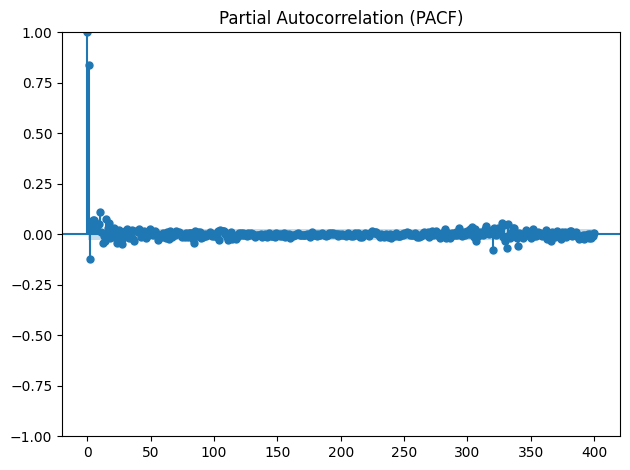


Significant PACF Lags (sorted by strength):
[1, 2, 10, 320, 15, 5, 4, 331, 17, 340, 327, 9, 3, 332, 8, 27, 329, 23, 7, 84, 12, 315, 330, 304, 307, 6, 16, 366, 37, 321, 293, 14, 324, 21, 336, 337, 104, 306, 325, 56, 111, 352]
LLR Test after adding lag 2: LR stat = 81.848, p = 0.0
LLR Test after adding lag 10: LR stat = 168.486, p = 0.0
LLR Test after adding lag 320: LR stat = 1047.894, p = 0.0
LLR Test after adding lag 15: LR stat = 3.385, p = 0.066
No significant improvement after adding lag 15. Stopping.

Final AutoReg Model Summary:
                            AutoReg Model Results                             
Dep. Variable:          Smoothed_Flow   No. Observations:                 5282
Model:             Restr. AutoReg(15)   Log Likelihood              -10748.605
Method:               Conditional MLE   S.D. of innovations              1.862
Date:                Fri, 20 Jun 2025   AIC                          21509.210
Time:                        17:23:23   BIC                    

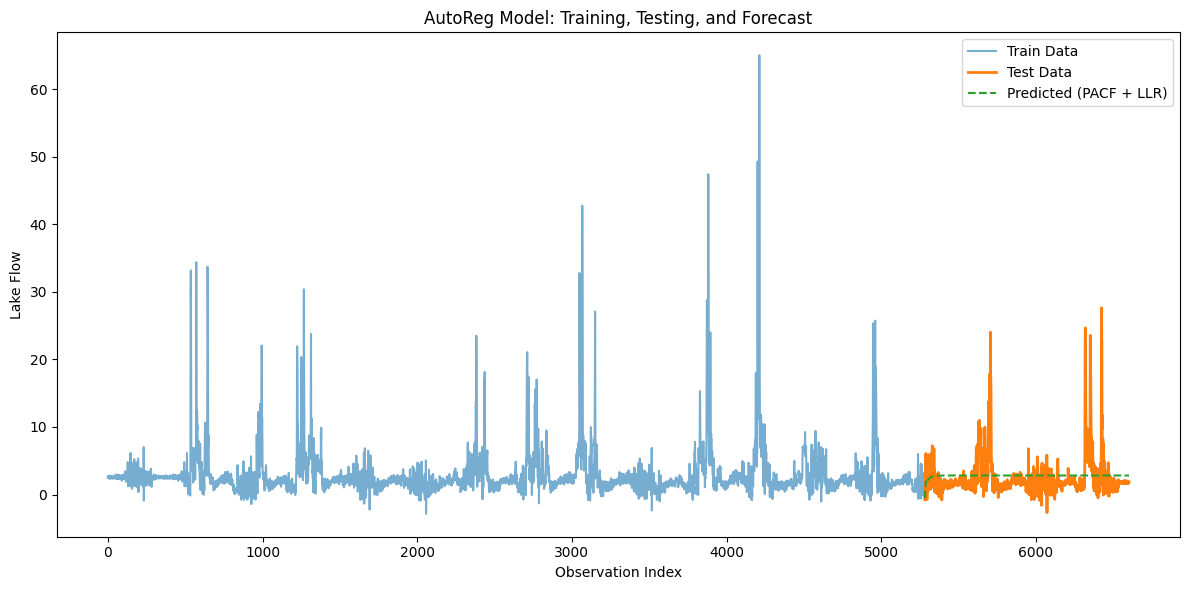

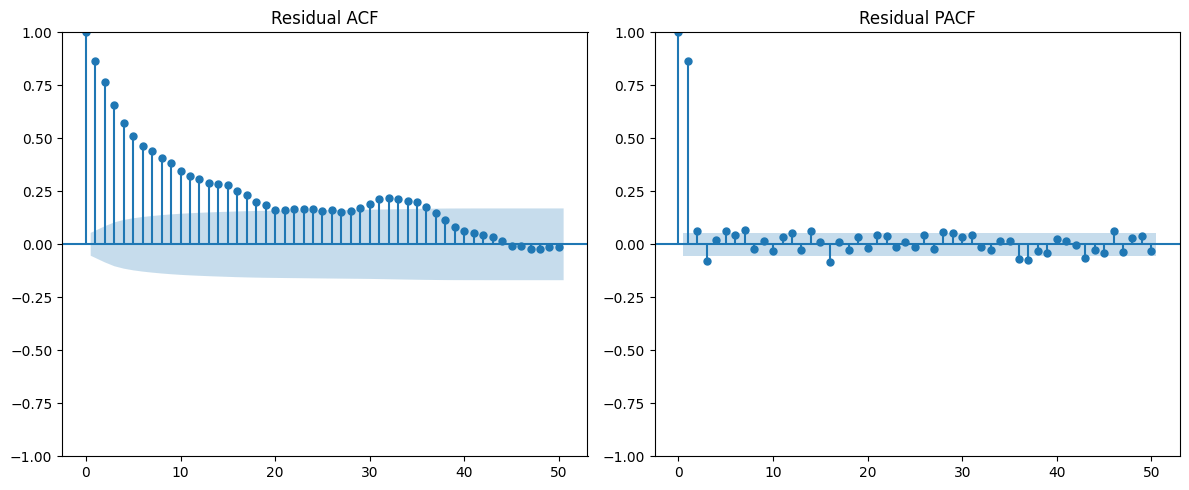

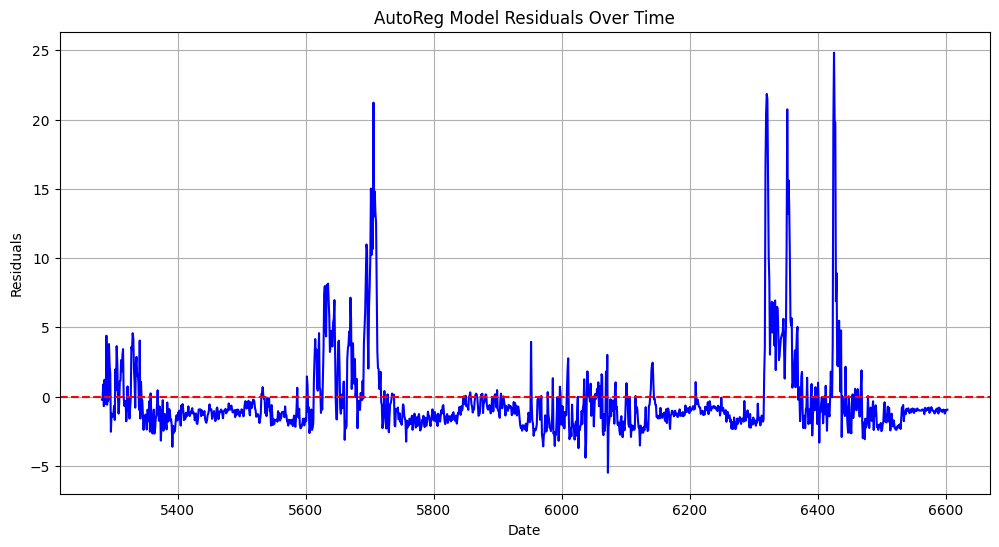

In [41]:
# Use pre-split training and testing data
train = y_train_flow
test = y_test_flow

# Plot the partial autocorrelation function
plt.figure(figsize=(10, 5))
plot_pacf(train, lags=400, method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# Compute PACF values and identify significant lags
pacf_vals = pacf(train, nlags=400, method='ywm')
n = len(train)
conf_bound = 1.96 / np.sqrt(n)

# Extract lags with significant partial correlation
lag_strength = [(lag, abs(val)) for lag, val in enumerate(pacf_vals) if lag != 0 and abs(val) > conf_bound]
lag_strength.sort(key=lambda x: x[1], reverse=True)
sorted_significant_lags = [lag for lag, _ in lag_strength]

print("\nSignificant PACF Lags (sorted by strength):")
print(sorted_significant_lags)

# Define LLR test between nested models
def llr_test(model_restricted, model_full):
    lr_stat = 2 * (model_full.llf - model_restricted.llf)
    df_diff = model_full.df_model - model_restricted.df_model
    p_value = chi2.sf(lr_stat, df_diff)
    return round(lr_stat, 3), round(p_value, 3)

# Select lags using LLR testing
selected_lags = []
prev_model = None

for i in range(len(sorted_significant_lags)):
    selected_lags.append(sorted_significant_lags[i])
    selected_lags = sorted(set(selected_lags))
    current_model = AutoReg(train, lags=selected_lags).fit()

    if prev_model is not None:
        lr_stat, p_val = llr_test(prev_model, current_model)
        print(f"LLR Test after adding lag {sorted_significant_lags[i]}: LR stat = {lr_stat}, p = {p_val}")
        if p_val > 0.05:
            print(f"No significant improvement after adding lag {sorted_significant_lags[i]}. Stopping.")
            selected_lags.pop()
            break

    prev_model = current_model

# Fit the final model
final_model = AutoReg(train, lags=selected_lags).fit()
pred = final_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate error metrics
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100
residuals = test - pred

# Output results
print("\nFinal AutoReg Model Summary:")
print(final_model.summary())
print(f"\nTest MAE: {round(mae, 3)}")
print(f"Test RMSE: {round(rmse, 3)}")
print(f"Test MAPE: {round(mape, 2)}%")
print(f"\nFinal Lags Used: {selected_lags}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train Data', alpha=0.6)
plt.plot(test.index, test.values, label='Test Data', linewidth=2)
plt.plot(test.index, pred, label='Predicted (PACF + LLR)', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Lake Flow')
plt.title('AutoReg Model: Training, Testing, and Forecast')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ACF and PACF of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.title('Residual ACF')

plt.subplot(1, 2, 2)
plot_pacf(residuals, lags=50, ax=plt.gca(), method='ywm')
plt.title('Residual PACF')
plt.tight_layout()
plt.show()

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('AutoReg Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

<Figure size 1000x500 with 0 Axes>

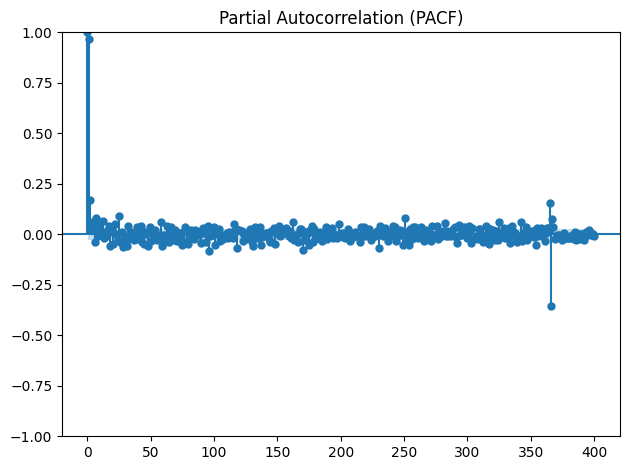


Significant PACF Lags (sorted by strength):
[1, 366, 2, 365, 25, 96, 7, 251, 170, 367, 230, 12, 118, 5, 28, 9, 58, 162, 342, 325, 59, 131, 48, 282, 31, 18, 137, 175, 101, 22, 75, 354, 254, 116, 249, 79, 3, 199, 317, 20, 45, 4, 148, 29, 293, 303, 292, 90, 177, 151, 276, 231, 334, 241, 17, 32, 272, 95, 63, 315, 166, 339, 42, 335, 301, 26, 144, 76, 312, 43, 61, 243, 259, 100, 77, 136, 368, 298, 66, 178, 130, 64, 94, 215, 296, 6, 346, 216, 361, 50, 188, 218, 290, 257, 39, 49, 271, 132, 263, 71, 235, 364, 185, 105, 304, 244, 329, 157, 91, 355, 333, 207, 237, 343, 19, 266, 123, 193, 322, 363, 347, 163, 37, 316, 147, 358, 55, 324, 78, 222, 117, 128, 386, 360, 10, 68, 289, 24, 104, 224, 168, 171]
LLR Test after adding lag 366: LR stat = 237.246, p = 0.0
LLR Test after adding lag 2: LR stat = 123.717, p = 0.0
LLR Test after adding lag 365: LR stat = 1689.316, p = 0.0
LLR Test after adding lag 25: LR stat = 24.94, p = 0.0
LLR Test after adding lag 96: LR stat = 9.058, p = 0.003
LLR Test after a

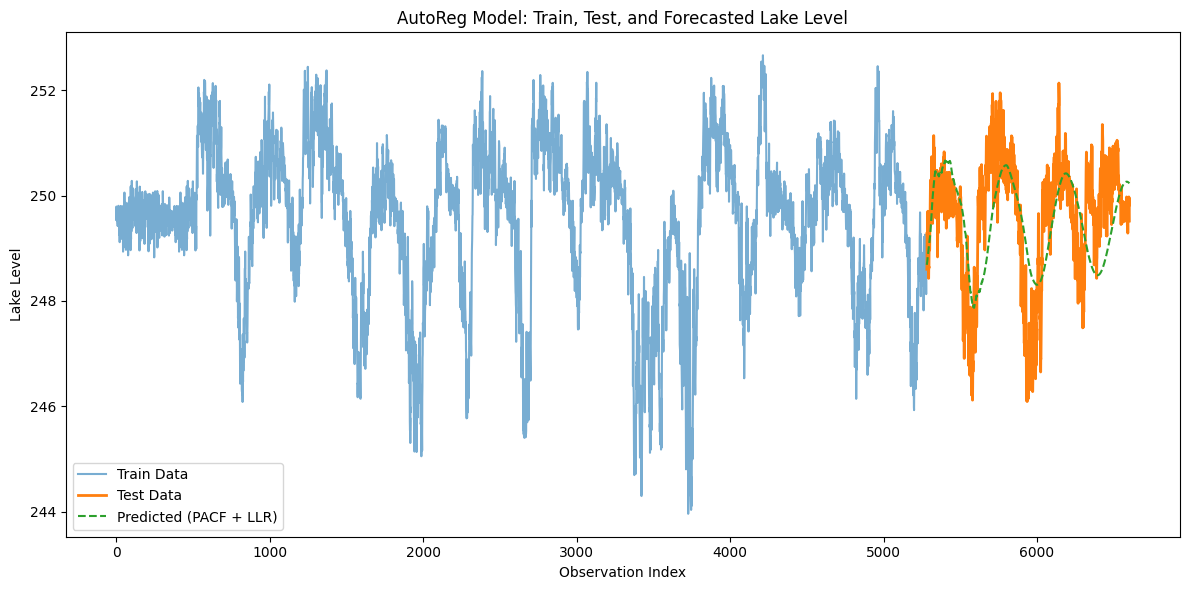

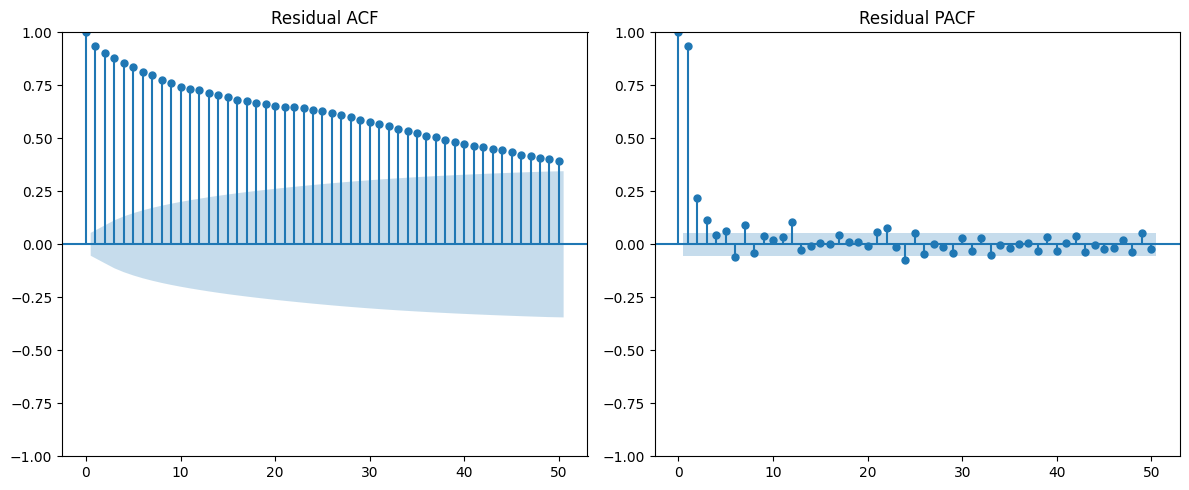

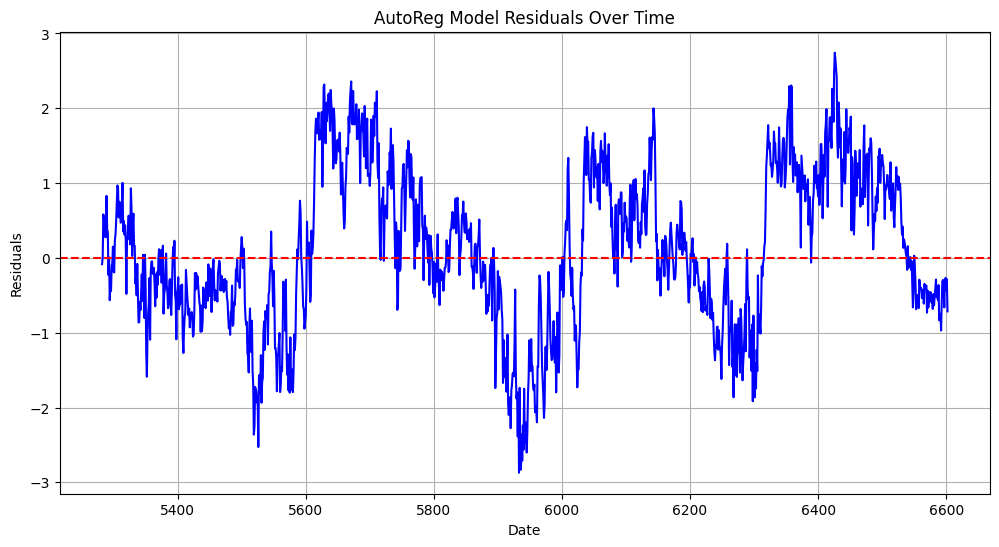

In [42]:
# Use pre-split training and test data
train = y_train_level
test = y_test_level

# Plot partial autocorrelation function
plt.figure(figsize=(10, 5))
plot_pacf(train, lags=400, method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# Compute PACF values and identify significant lags
pacf_vals = pacf(train, nlags=400, method='ywm')
n = len(train)
conf_bound = 1.96 / np.sqrt(n)

# Filter significant lags based on PACF threshold
lag_strength = [(lag, abs(val)) for lag, val in enumerate(pacf_vals) if lag != 0 and abs(val) > conf_bound]
lag_strength.sort(key=lambda x: x[1], reverse=True)
sorted_significant_lags = [lag for lag, _ in lag_strength]

print("\nSignificant PACF Lags (sorted by strength):")
print(sorted_significant_lags)

# Likelihood ratio test for comparing nested models
def llr_test(model_restricted, model_full):
    lr_stat = 2 * (model_full.llf - model_restricted.llf)
    df_diff = model_full.df_model - model_restricted.df_model
    p_value = chi2.sf(lr_stat, df_diff)
    return round(lr_stat, 3), round(p_value, 3)

# Select PACF lags using LLR tests
selected_lags = []
prev_model = None

for i in range(len(sorted_significant_lags)):
    selected_lags.append(sorted_significant_lags[i])
    selected_lags = sorted(set(selected_lags))  # Ensure uniqueness and order
    current_model = AutoReg(train, lags=selected_lags).fit()

    if prev_model is not None:
        lr_stat, p_val = llr_test(prev_model, current_model)
        print(f"LLR Test after adding lag {sorted_significant_lags[i]}: LR stat = {lr_stat}, p = {p_val}")
        if p_val > 0.05:
            print(f"No significant improvement after adding lag {sorted_significant_lags[i]}. Stopping.")
            selected_lags.pop()
            break

    prev_model = current_model

# Fit final model and generate predictions
final_model = AutoReg(train, lags=selected_lags).fit()
pred = final_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Evaluate performance
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

residuals = test - pred

# Print model summary and performance
print("\nFinal AutoReg Model Summary:")
print(final_model.summary())
print(f"\nTest MAE: {round(mae, 3)}")
print(f"Test RMSE: {round(rmse, 3)}")
print(f"Test MAPE: {round(mape, 2)}%")
print(f"\nFinal Lags Used: {selected_lags}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train Data', alpha=0.6)
plt.plot(test.index, test.values, label='Test Data', linewidth=2)
plt.plot(test.index, pred, label='Predicted (PACF + LLR)', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Lake Level')
plt.title('AutoReg Model: Train, Test, and Forecasted Lake Level')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ACF and PACF of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.title('Residual ACF')

plt.subplot(1, 2, 2)
plot_pacf(residuals, lags=50, ax=plt.gca(), method='ywm')
plt.title('Residual PACF')
plt.tight_layout()
plt.show()

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('AutoReg Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# **MA models**

<Figure size 1000x500 with 0 Axes>

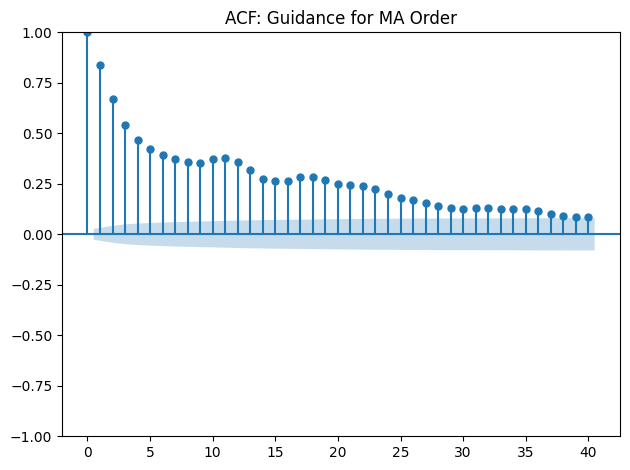

LLR Test MA(0) vs MA(1): LR stat = 3876.526, p = 0.0
LLR Test MA(1) vs MA(2): LR stat = 1464.167, p = 0.0
LLR Test MA(2) vs MA(3): LR stat = 625.81, p = 0.0

Final MA(3) Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Smoothed_Flow   No. Observations:                 5282
Model:                 ARIMA(0, 0, 3)   Log Likelihood              -11126.699
Date:                Fri, 20 Jun 2025   AIC                          22263.398
Time:                        17:23:36   BIC                          22296.259
Sample:                             0   HQIC                         22274.883
                               - 5282                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8201    

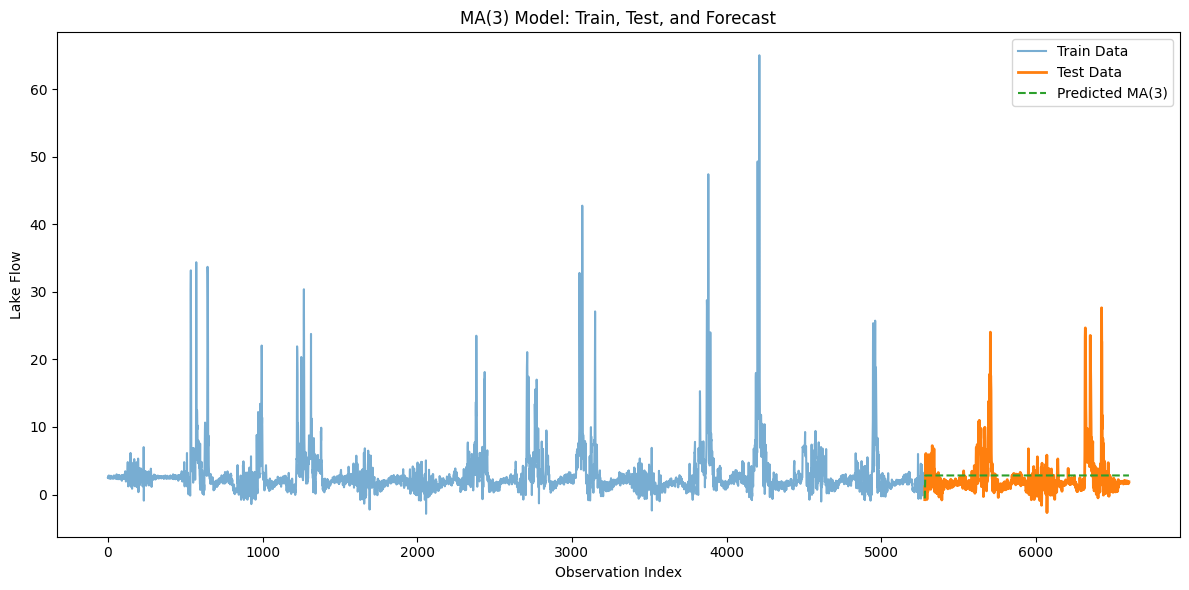

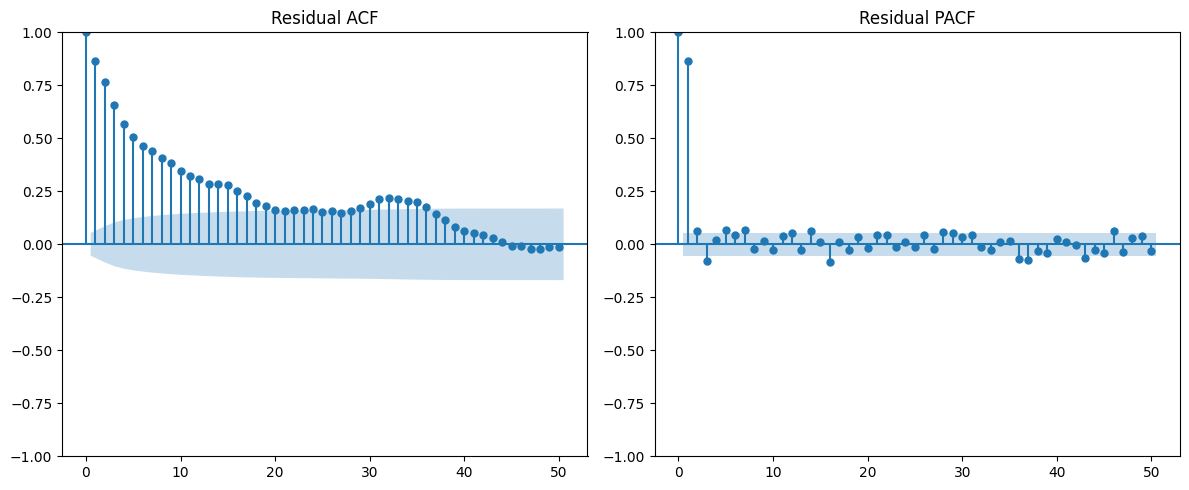

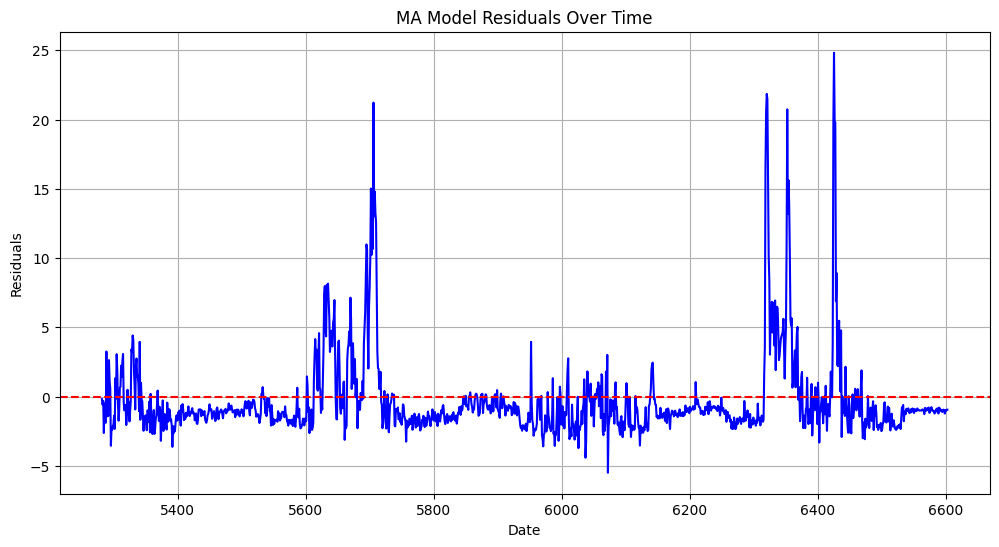

In [43]:



# 1. Load pre-split training and testing sets
train = y_train_flow
test = y_test_flow

# 2. Plot ACF to guide MA order selection
plt.figure(figsize=(10, 5))
plot_acf(train, lags=40)
plt.title("ACF: Guidance for MA Order")
plt.tight_layout()
plt.show()

# 3. Likelihood Ratio Test for nested model comparison
def llr_test(model_restricted, model_full):
    lr_stat = 2 * (model_full.llf - model_restricted.llf)
    df_diff = model_full.df_model - model_restricted.df_model
    p_value = chi2.sf(lr_stat, df_diff)
    return round(lr_stat, 3), round(p_value, 3)

# 4. Iteratively fit MA(q) models and apply LLR test
max_q = 3
selected_q = 0
prev_model = ARIMA(train, order=(0, 0, 0)).fit()

for q in range(1, max_q + 1):
    try:
        current_model = ARIMA(train, order=(0, 0, q)).fit()
        lr_stat, p_val = llr_test(prev_model, current_model)
        print(f"LLR Test MA({q-1}) vs MA({q}): LR stat = {lr_stat}, p = {p_val}")

        if p_val > 0.05:
            print(f"\nNo significant improvement beyond MA({q-1}). Stopping.")
            break

        selected_q = q
        prev_model = current_model

    except Exception as e:
        print(f"Model MA({q}) failed to fit: {e}")
        break

# 5. Fit final selected MA model and forecast
final_model = ARIMA(train, order=(0, 0, selected_q)).fit()
pred = final_model.forecast(steps=len(test))

# 6. Evaluate forecast performance
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100
residuals = test - pred

# 7. Output model summary and evaluation
print(f"\nFinal MA({selected_q}) Model Summary:")
print(final_model.summary())
print(f"\nTest MAE: {round(mae, 3)}")
print(f"Test RMSE: {round(rmse, 3)}")
print(f"Test MAPE: {round(mape, 2)}%")

# 8. Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train Data', alpha=0.6)
plt.plot(test.index, test.values, label='Test Data', linewidth=2)
plt.plot(test.index, pred, label=f'Predicted MA({selected_q})', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Lake Flow')
plt.title(f'MA({selected_q}) Model: Train, Test, and Forecast')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Plot ACF and PACF of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.title('Residual ACF')

plt.subplot(1, 2, 2)
plot_pacf(residuals, lags=50, ax=plt.gca(), method='ywm')
plt.title('Residual PACF')
plt.tight_layout()
plt.show()

# 10. Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('MA Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


<Figure size 1000x500 with 0 Axes>

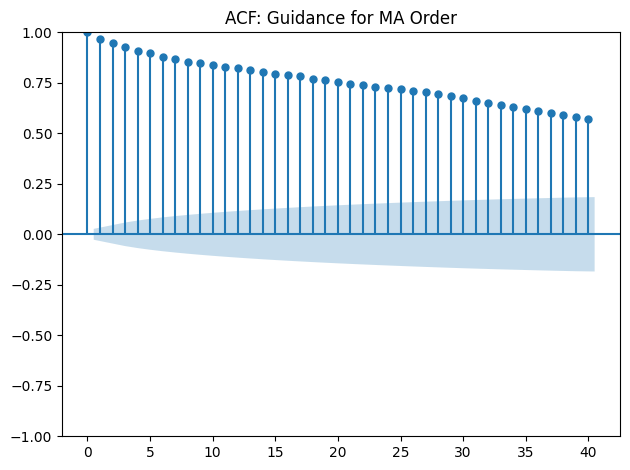

LLR Test MA(0) vs MA(1): LR stat = 5418.09, p = 0.0
LLR Test MA(1) vs MA(2): LR stat = 2939.881, p = 0.0
LLR Test MA(2) vs MA(3): LR stat = 1883.864, p = 0.0

Final MA(3) Model Summary:
                                SARIMAX Results                                
Dep. Variable:     Smoothed_Lake_Level   No. Observations:                 5282
Model:                  ARIMA(0, 0, 3)   Log Likelihood               -4454.143
Date:                 Fri, 20 Jun 2025   AIC                           8918.285
Time:                         17:23:54   BIC                           8951.146
Sample:                              0   HQIC                          8929.770
                                - 5282                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        249

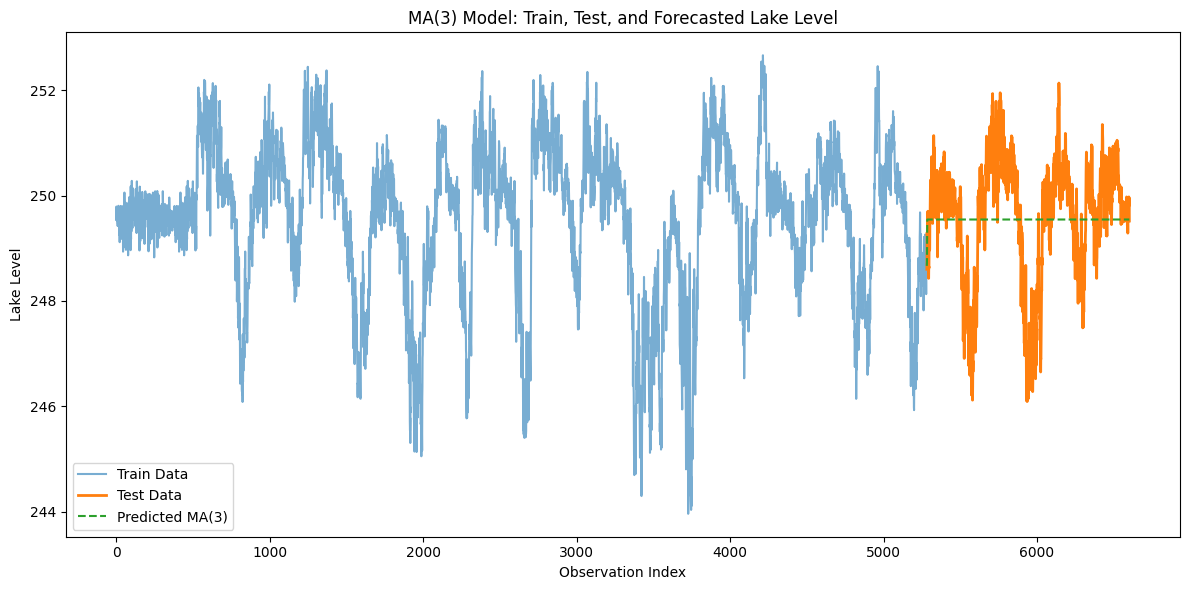

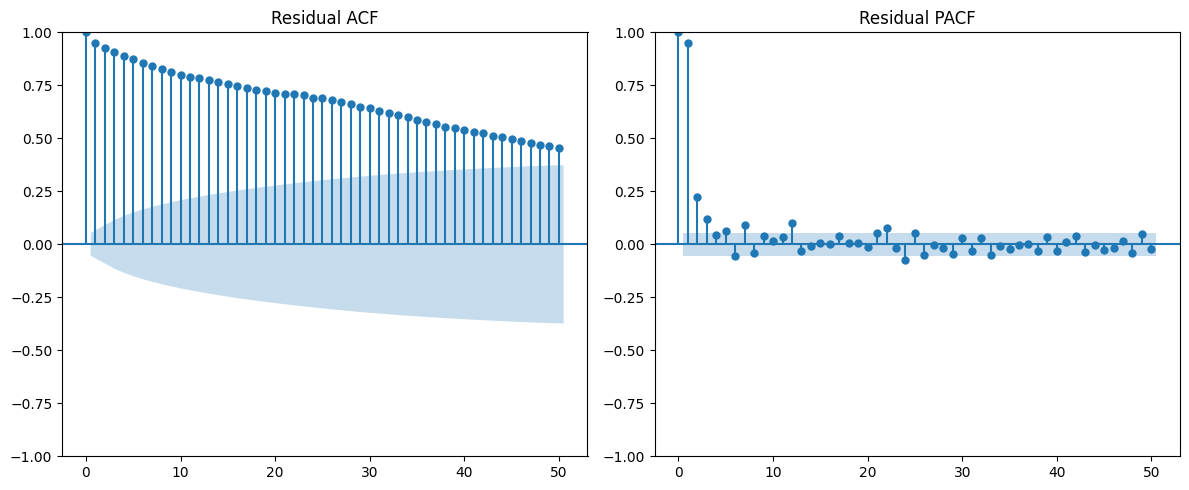

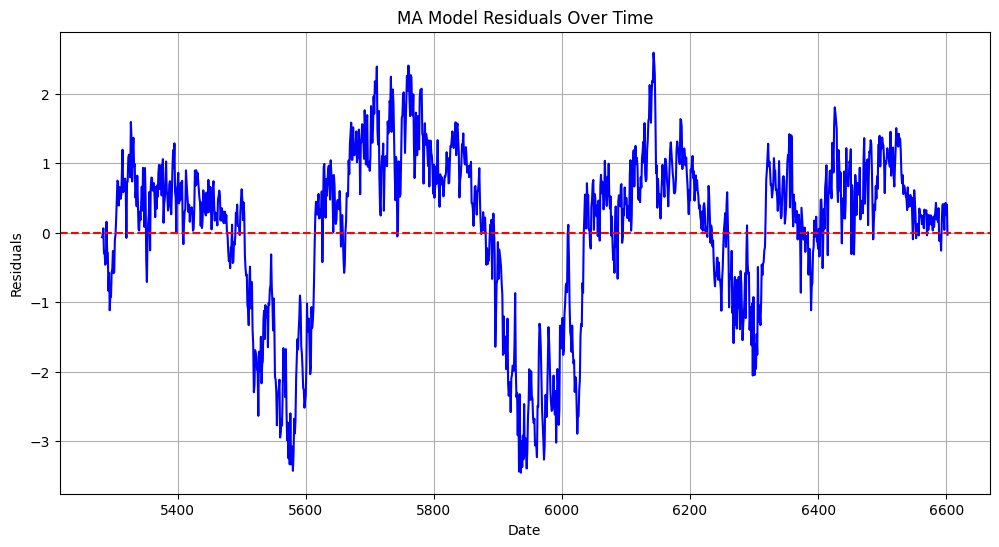

In [44]:


# 1. Use provided training and test splits
train = y_train_level
test = y_test_level

# 2. Plot ACF to guide MA order selection
plt.figure(figsize=(10, 5))
plot_acf(train, lags=40)
plt.title("ACF: Guidance for MA Order")
plt.tight_layout()
plt.show()

# 3. Likelihood ratio test function for comparing nested models
def llr_test(model_restricted, model_full):
    lr_stat = 2 * (model_full.llf - model_restricted.llf)
    df_diff = model_full.df_model - model_restricted.df_model
    p_value = chi2.sf(lr_stat, df_diff)
    return round(lr_stat, 3), round(p_value, 3)

# 4. Fit MA(q) models and apply LLR test to choose optimal q
max_q = 3
selected_q = 0
prev_model = ARIMA(train, order=(0, 0, 0)).fit()

for q in range(1, max_q + 1):
    try:
        current_model = ARIMA(train, order=(0, 0, q)).fit()
        lr_stat, p_val = llr_test(prev_model, current_model)
        print(f"LLR Test MA({q-1}) vs MA({q}): LR stat = {lr_stat}, p = {p_val}")

        if p_val > 0.05:
            print(f"\nNo significant improvement beyond MA({q-1}). Stopping.")
            break

        selected_q = q
        prev_model = current_model

    except Exception as e:
        print(f"Model MA({q}) failed: {e}")
        break

# 5. Fit final MA model and generate predictions
final_model = ARIMA(train, order=(0, 0, selected_q)).fit()
pred = final_model.forecast(steps=len(test))

# 6. Calculate evaluation metrics
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

# Compute residuals
residuals = test - pred

# 7. Output model summary and evaluation
print(f"\nFinal MA({selected_q}) Model Summary:")
print(final_model.summary())
print(f"\nTest MAE: {round(mae, 3)}")
print(f"Test RMSE: {round(rmse, 3)}")
print(f"Test MAPE: {round(mape, 2)}%")

# 8. Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train Data', alpha=0.6)
plt.plot(test.index, test.values, label='Test Data', linewidth=2)
plt.plot(test.index, pred, label=f'Predicted MA({selected_q})', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Lake Level')
plt.title(f'MA({selected_q}) Model: Train, Test, and Forecasted Lake Level')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Plot ACF and PACF of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.title('Residual ACF')

plt.subplot(1, 2, 2)
plot_pacf(residuals, lags=50, ax=plt.gca(), method='ywm')
plt.title('Residual PACF')
plt.tight_layout()
plt.show()

# 10. Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('MA Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


# **Armax**

/tmp/ipython-input-45-34878108.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_monthly = df_s["Smoothed_Flow"].resample("M").mean()
/tmp/ipython-input-45-34878108.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exog_monthly = df_s[['Mean_Rainfall', 'Mean_Temp', 'Actual_Lake_Level']].resample("M").mean()
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          Smoothed_Flow   No. Observations:                  173
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -352.375
Date:                Fri, 20 Jun 2025   AIC                            720.751
Time:                        17:23:56   BIC                            745.977
Sample:                    07-31-2006   HQIC                           730.985
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0741      0.130      0.570      0.569      -0.181       0.329
x2            -0.2272      0.228     -0.994      0.320      -0.675       0.221
x3             1.0839      0.206      5.269      0.0

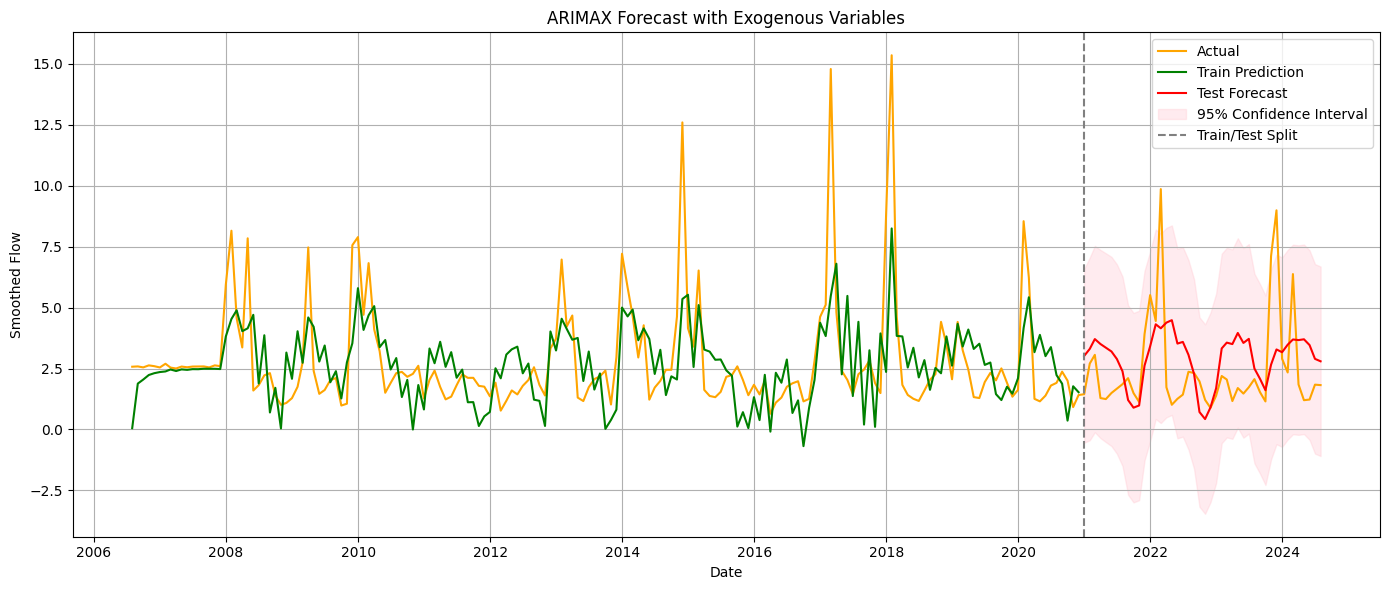

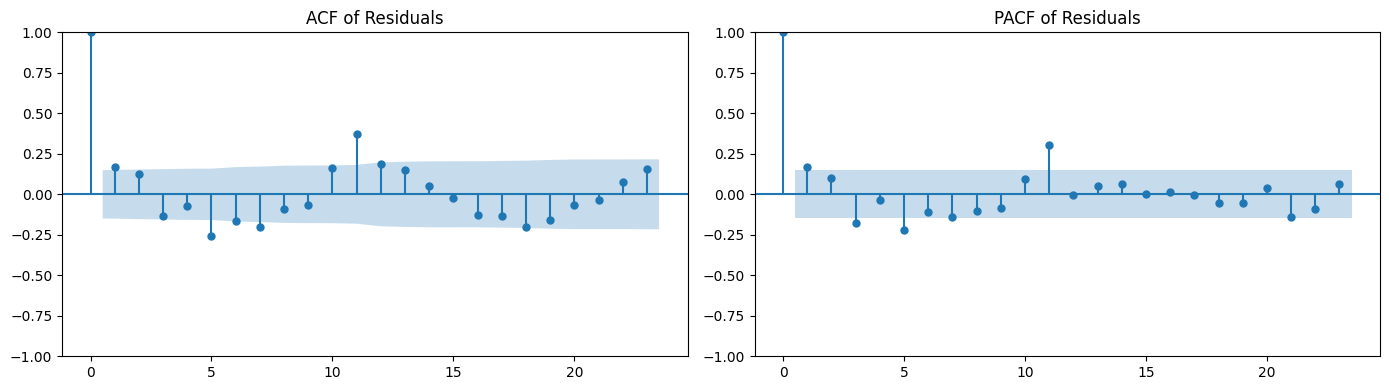


Ljung-Box Test (lag=12):
      lb_stat     lb_pvalue
12  75.688349  2.722430e-11

Jarque-Bera Test:
JB Statistic: 258.20, p-value: 0.0000, Skew: 1.59, Kurtosis: 8.07

Model Selection Criteria:
AIC: 720.75
BIC: 745.98

Forecast Accuracy:
MAE  : 1.61
RMSE : 2.08
MAPE : 81.51%


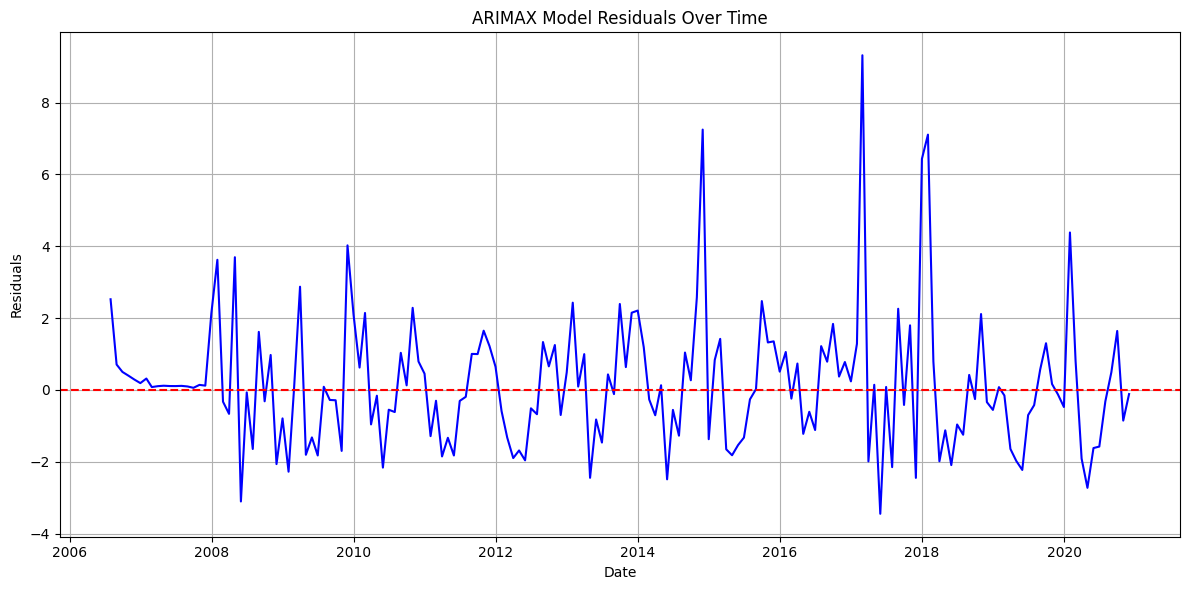

In [45]:
# Prepare data
df_s = df_flow.copy()
df_s['Date'] = pd.to_datetime(df_s['Date'])
df_s.set_index('Date', inplace=True)

# Resample target and exogenous variables to monthly frequency
y_monthly = df_s["Smoothed_Flow"].resample("M").mean()
exog_monthly = df_s[['Mean_Rainfall', 'Mean_Temp', 'Actual_Lake_Level']].resample("M").mean()

# Train/test split
split_idx = int(len(y_monthly) * 0.8)
y_train = y_monthly.iloc[:split_idx]
y_test = y_monthly.iloc[split_idx:]
exog_train = exog_monthly.iloc[:split_idx]
exog_test = exog_monthly.iloc[split_idx:]

# Scale exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

# Fit ARIMAX model (non-seasonal ARIMA with exogenous features)
model = SARIMAX(
    y_train,
    exog=exog_train_scaled,
    order=(2, 0, 2),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results = model.fit(disp=False)

# Print model summary
print(results.summary())

# Forecast
y_train_pred = results.fittedvalues
y_test_forecast = results.get_forecast(steps=len(y_test), exog=exog_test_scaled)
y_test_pred = y_test_forecast.predicted_mean
conf_int = y_test_forecast.conf_int()

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(y_monthly, label='Actual', color='orange')
plt.plot(y_train_pred, label='Train Prediction', color='green')
plt.plot(y_test_pred, label='Test Forecast', color='red')
plt.fill_between(
    y_test_pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
    color='pink', alpha=0.3, label='95% Confidence Interval'
)
plt.axvline(y_test.index[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title('ARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Smoothed Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual diagnostics
residuals = results.resid

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals.dropna(), ax=axes[0])
plot_pacf(residuals.dropna(), ax=axes[1])
axes[0].set_title("ACF of Residuals")
axes[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

# Ljung-Box test
ljung_box = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("\nLjung-Box Test (lag=12):")
print(ljung_box)

# Jarque-Bera test
jb_stat, jb_pval, skew, kurt = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Statistic: {jb_stat:.2f}, p-value: {jb_pval:.4f}, Skew: {skew:.2f}, Kurtosis: {kurt:.2f}")

# Model selection metrics
print("\nModel Selection Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# Forecast accuracy
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape = np.mean(np.abs((y_test - y_test_pred) / y_test.replace(0, np.nan))) * 100

print("\nForecast Accuracy:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('ARIMAX Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-46-1579275723.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_monthly = df_lake_lake["Actual_Lake_Level"].resample("M").mean()
/tmp/ipython-input-46-1579275723.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exog_monthly = df_lake_lake[['Mean_Rainfall', 'Mean_Temp', 'Actual_Flow_Rate']].resample("M").mean()


                               SARIMAX Results                                
Dep. Variable:      Actual_Lake_Level   No. Observations:                  173
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -210.528
Date:                Fri, 20 Jun 2025   AIC                            437.056
Time:                        17:23:57   BIC                            462.282
Sample:                    07-31-2006   HQIC                           447.290
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0423      0.069     -0.616      0.538      -0.177       0.092
x2            -0.3973      0.113     -3.510      0.000      -0.619      -0.175
x3             0.3492      0.064      5.498      0.0

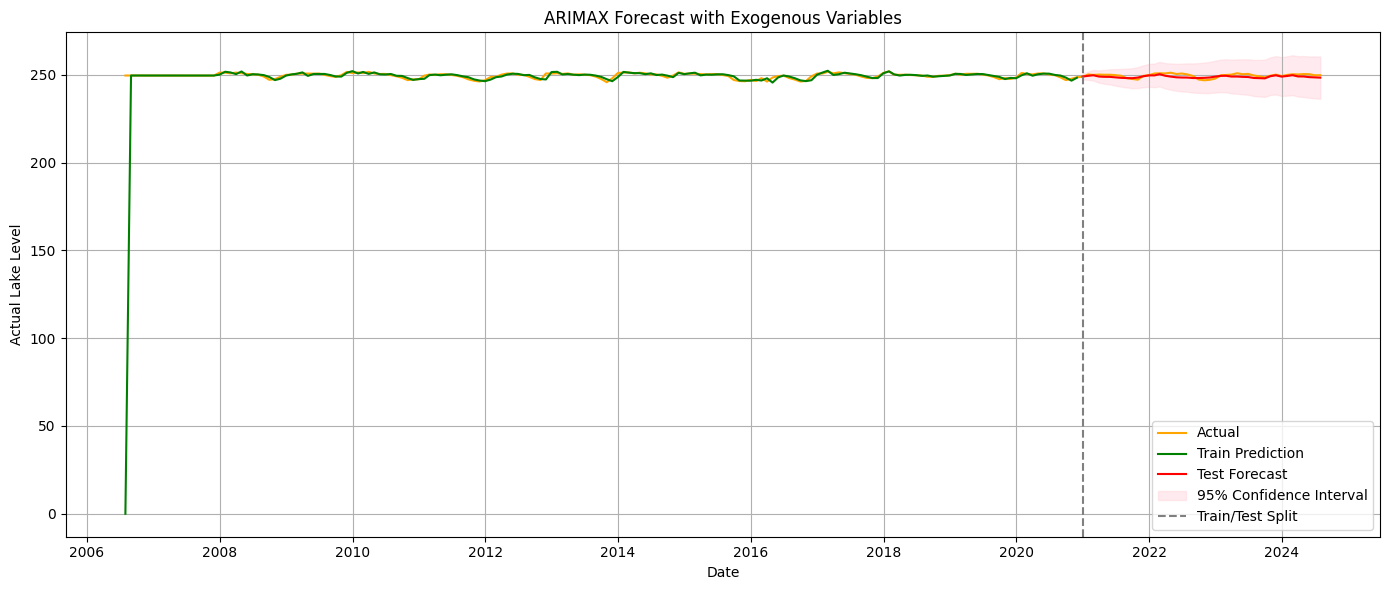

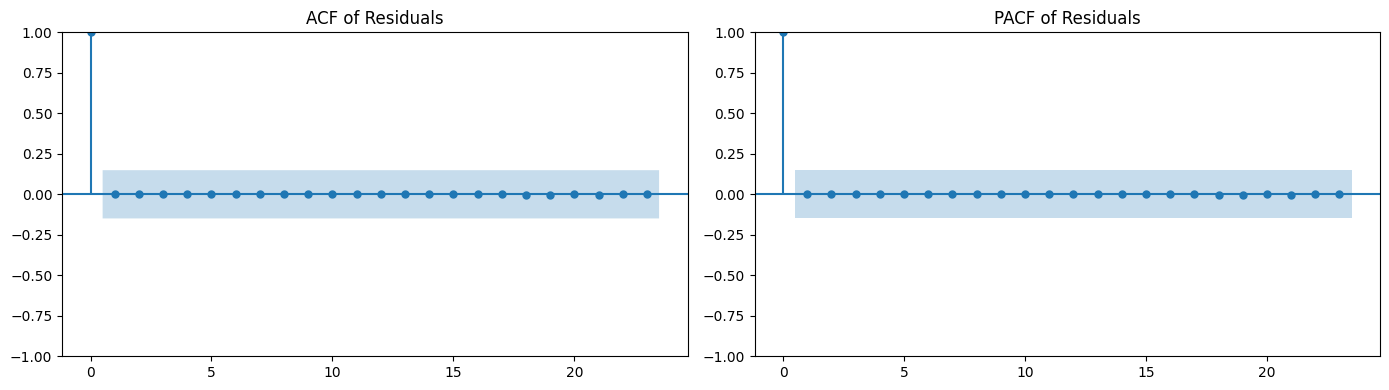


Ljung-Box Test (lag=12):
     lb_stat  lb_pvalue
12  0.000209        1.0

Jarque-Bera Test:
JB Statistic: 206909.96, p-value: 0.0000, Skew: 13.00, Kurtosis: 170.42

Model Information Criteria:
AIC: 437.06
BIC: 462.28

Forecast Accuracy:
MAE  : 1.02
RMSE : 1.18
MAPE : 0.41%


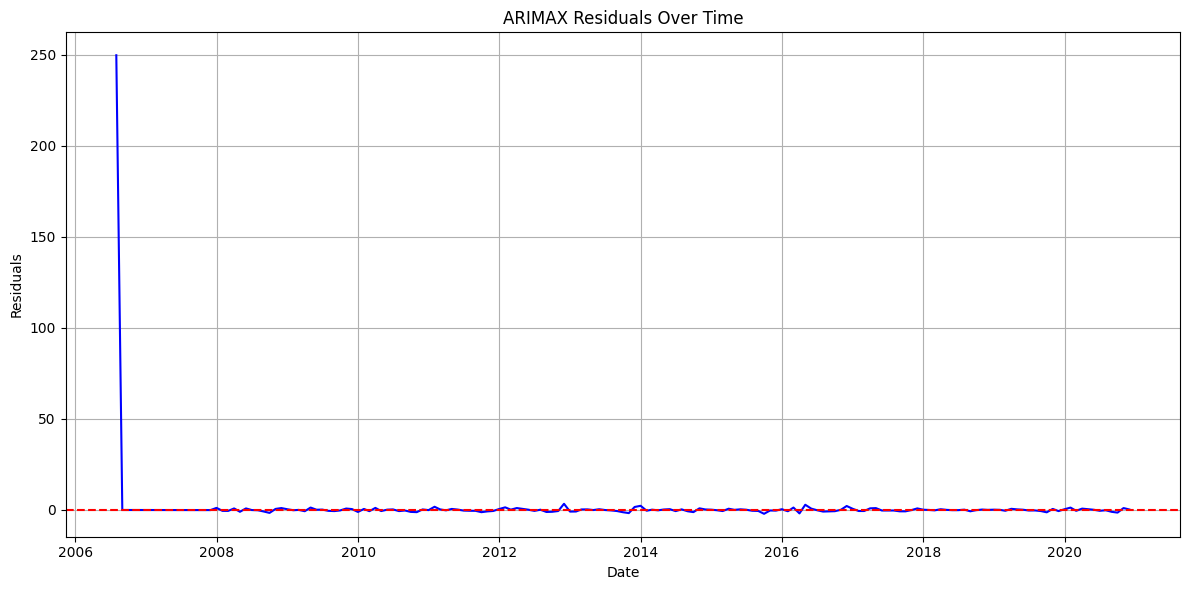

In [46]:
# Load and prepare the dataset
df_lake_lake = df.copy()
df_lake_lake['Date'] = pd.to_datetime(df_lake_lake['Date'])
df_lake_lake.set_index('Date', inplace=True)

# Target variable: monthly lake level
y_monthly = df_lake_lake["Actual_Lake_Level"].resample("M").mean()

# Exogenous variables: monthly mean values
exog_monthly = df_lake_lake[['Mean_Rainfall', 'Mean_Temp', 'Actual_Flow_Rate']].resample("M").mean()

# Train/test split (80/20)
split_idx = int(len(y_monthly) * 0.8)
y_train = y_monthly.iloc[:split_idx]
y_test = y_monthly.iloc[split_idx:]
exog_train = exog_monthly.iloc[:split_idx]
exog_test = exog_monthly.iloc[split_idx:]

# Standardize the exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

# Fit ARIMAX model (non-seasonal)
model = SARIMAX(
    y_train,
    exog=exog_train_scaled,
    order=(2, 0, 2),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results = model.fit(disp=False)

# Model summary
print(results.summary())

# Forecast
y_train_pred = results.fittedvalues
y_test_forecast = results.get_forecast(steps=len(y_test), exog=exog_test_scaled)
y_test_pred = y_test_forecast.predicted_mean
conf_int = y_test_forecast.conf_int()

# Plot actual and predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_monthly, label='Actual', color='orange')
plt.plot(y_train_pred, label='Train Prediction', color='green')
plt.plot(y_test_pred, label='Test Forecast', color='red')
plt.fill_between(
    y_test_pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
    color='pink', alpha=0.3, label='95% Confidence Interval'
)
plt.axvline(y_test.index[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title('ARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Actual Lake Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze residuals
residuals = results.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals.dropna(), ax=axes[0])
plot_pacf(residuals.dropna(), ax=axes[1])
axes[0].set_title("ACF of Residuals")
axes[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("\nLjung-Box Test (lag=12):")
print(ljung_box)

# Jarque-Bera test for normality
jb_stat, jb_pval, skew, kurt = jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"JB Statistic: {jb_stat:.2f}, p-value: {jb_pval:.4f}, Skew: {skew:.2f}, Kurtosis: {kurt:.2f}")

# Model information criteria
print("\nModel Information Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# Forecast accuracy metrics
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape = np.mean(np.abs((y_test - y_test_pred) / y_test.replace(0, np.nan))) * 100

print("\nForecast Accuracy:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('ARIMAX Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


# **Sarmax**

/tmp/ipython-input-47-1831717860.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_monthly = df_s["Smoothed_Flow"].resample("M").mean()
/tmp/ipython-input-47-1831717860.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exog_monthly = df_s[['Mean_Rainfall', 'Mean_Temp', 'Actual_Lake_Level']].resample("M").mean()
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                        Smoothed_Flow   No. Observations:                  173
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -335.625
Date:                              Fri, 20 Jun 2025   AIC                            691.250
Time:                                      17:24:00   BIC                            722.783
Sample:                                  07-31-2006   HQIC                           704.043
                                       - 11-30-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0618      0.135     -0.458      0.647      -0.327       0.203
x2            -0.05

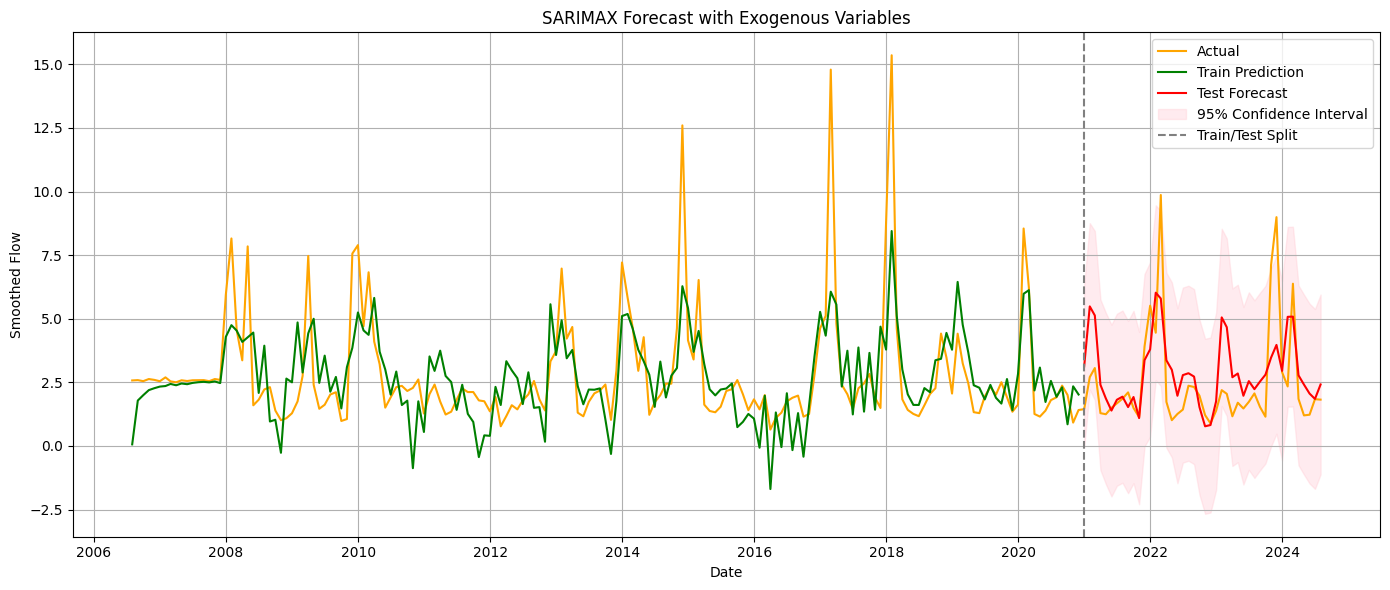


Coefficients and P-values:
x1          6.472626e-01
x2          8.614965e-01
x3          2.231216e-21
ar.L1       9.264157e-06
ar.L2       5.213514e-47
ma.L1       9.999688e-01
ma.L2       9.894590e-01
ar.S.L12    7.037707e-38
ma.S.L12    1.743744e-06
sigma2      9.894549e-01
dtype: float64


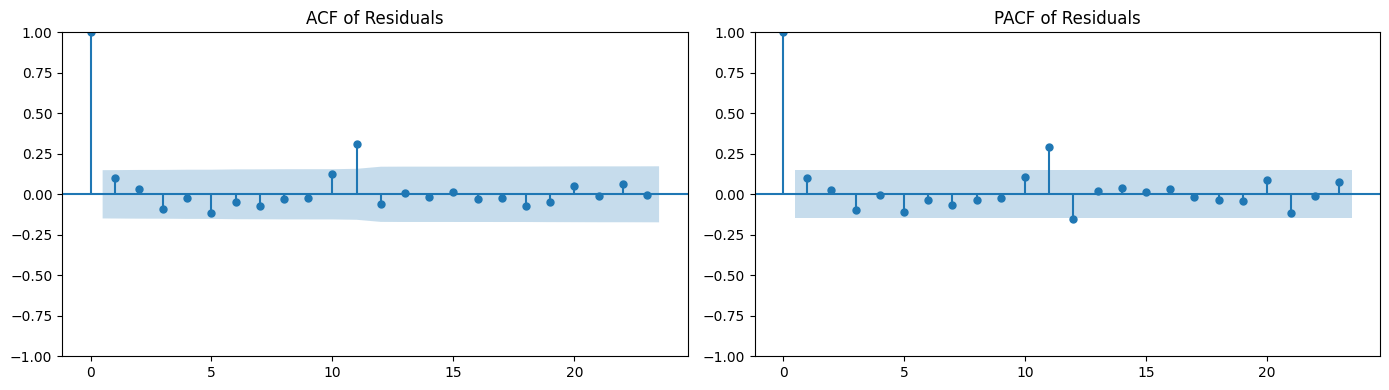


Ljung-Box Test (lag=12):
      lb_stat  lb_pvalue
12  29.129921   0.003769

Jarque-Bera Test for Residuals:
JB Statistic: 307.24, p-value: 0.0000, Skew: 1.66, Kurtosis: 8.62

Model Selection Criteria:
AIC: 691.25
BIC: 722.78

Forecast Accuracy on Test Set:
MAE  : 1.23
RMSE : 1.68
MAPE : 55.69%


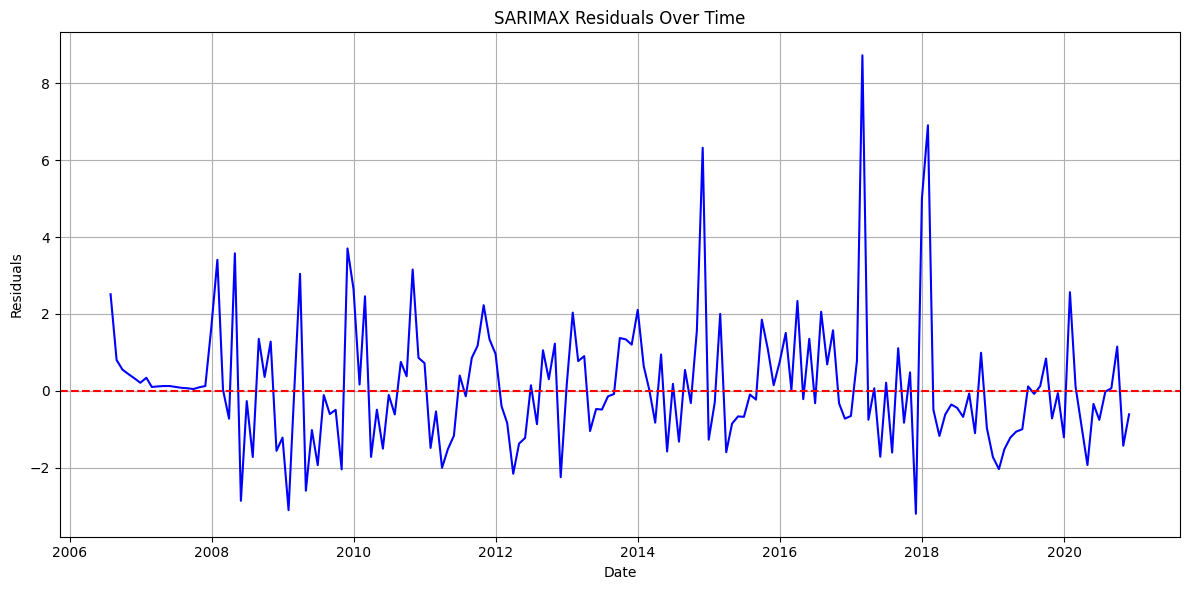

In [47]:
# Copy and prepare data
df_s = df_flow.copy()
df_s['Date'] = pd.to_datetime(df_s['Date'])
df_s.set_index('Date', inplace=True)

# Resample to monthly average for the target variable
y_monthly = df_s["Smoothed_Flow"].resample("M").mean()

# Prepare monthly exogenous variables
exog_monthly = df_s[['Mean_Rainfall', 'Mean_Temp', 'Actual_Lake_Level']].resample("M").mean()

# Split into train and test sets (80/20)
split_idx = int(len(y_monthly) * 0.8)
y_train = y_monthly.iloc[:split_idx]
y_test = y_monthly.iloc[split_idx:]
exog_train = exog_monthly.iloc[:split_idx]
exog_test = exog_monthly.iloc[split_idx:]

# Standardize exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

# Fit SARIMAX model with seasonal and exogenous terms
model = SARIMAX(
    y_train,
    exog=exog_train_scaled,
    order=(2, 0, 2),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results = model.fit(disp=False)

# Model summary
print(results.summary())

# Forecasting
y_train_pred = results.fittedvalues
y_test_forecast = results.get_forecast(steps=len(y_test), exog=exog_test_scaled)
y_test_pred = y_test_forecast.predicted_mean
conf_int = y_test_forecast.conf_int()

# Plot actual and predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_monthly, label='Actual', color='orange')
plt.plot(y_train_pred, label='Train Prediction', color='green')
plt.plot(y_test_pred, label='Test Forecast', color='red')
plt.fill_between(
    y_test_pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
    color='pink', alpha=0.3, label='95% Confidence Interval'
)
plt.axvline(y_test.index[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Smoothed Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Coefficient significance
print("\nCoefficients and P-values:")
print(results.pvalues)

# ACF and PACF of residuals
residuals = results.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals.dropna(), ax=axes[0])
plot_pacf(residuals.dropna(), ax=axes[1])
axes[0].set_title("ACF of Residuals")
axes[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("\nLjung-Box Test (lag=12):")
print(ljung_box)

# Jarque-Bera test for normality
jb_stat, jb_pval, skew, kurt = jarque_bera(residuals)
print("\nJarque-Bera Test for Residuals:")
print(f"JB Statistic: {jb_stat:.2f}, p-value: {jb_pval:.4f}, Skew: {skew:.2f}, Kurtosis: {kurt:.2f}")

# Information criteria
print("\nModel Selection Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# Forecast accuracy metrics
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape = np.mean(np.abs((y_test - y_test_pred) / y_test.replace(0, np.nan))) * 100

print("\nForecast Accuracy on Test Set:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('SARIMAX Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-48-2061411515.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_monthly = df_lake["Actual_Lake_Level"].resample("M").mean()
/tmp/ipython-input-48-2061411515.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exog_monthly = df_lake[['Mean_Rainfall', 'Mean_Temp', 'Actual_Flow_Rate']].resample("M").mean()
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                    Actual_Lake_Level   No. Observations:                  173
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -237.026
Date:                              Fri, 20 Jun 2025   AIC                            494.051
Time:                                      17:24:06   BIC                            525.584
Sample:                                  07-31-2006   HQIC                           506.844
                                       - 11-30-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0584      0.034      1.706      0.088      -0.009       0.125
x2            -0.47

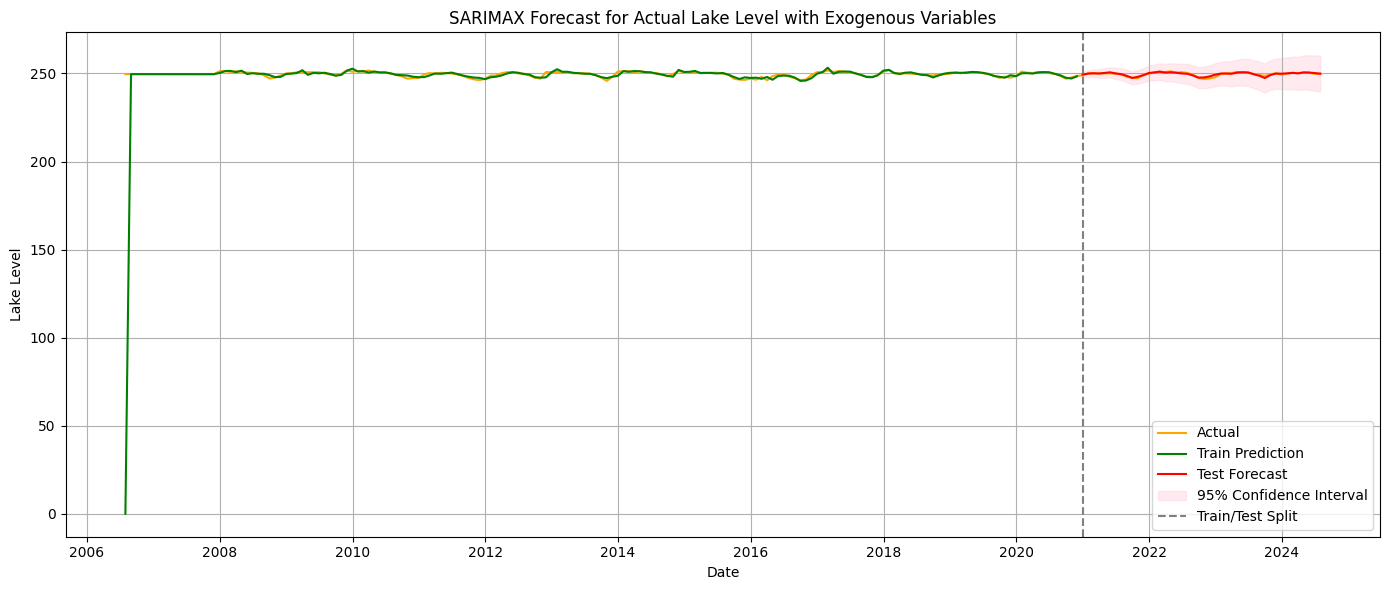


Model Coefficients and P-values:
x1          8.800673e-02
x2          2.261584e-03
x3          8.477660e-16
ar.L1       0.000000e+00
ar.L2       0.000000e+00
ma.L1       0.000000e+00
ma.L2       0.000000e+00
ar.S.L12    0.000000e+00
ma.S.L12    0.000000e+00
sigma2      0.000000e+00
dtype: float64


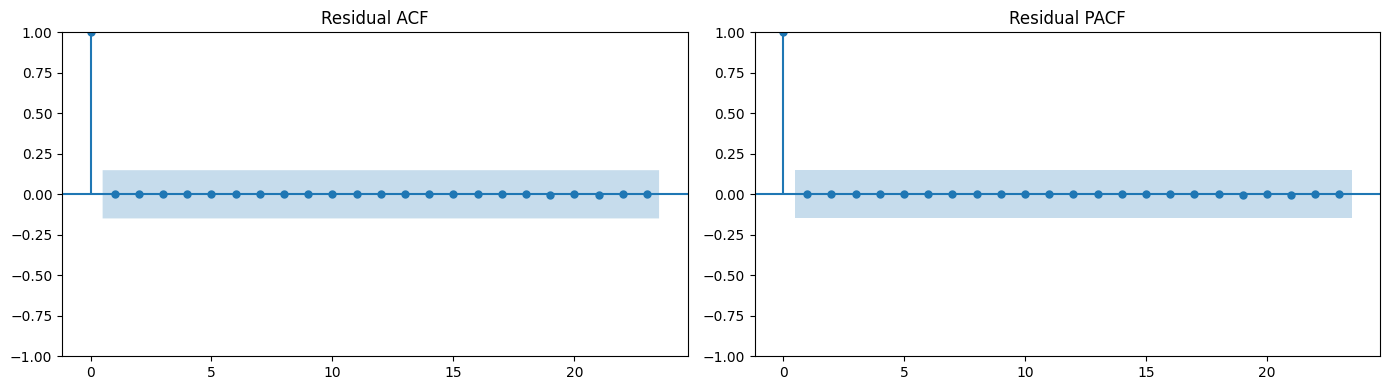


Ljung-Box Test (lag=12):
     lb_stat  lb_pvalue
12  0.000181        1.0

Jarque-Bera Test for Residuals:
JB Statistic: 207133.59, p-value: 0.0000, Skew: 13.01, Kurtosis: 170.51

Model Selection Criteria:
AIC: 494.05
BIC: 525.58

Forecast Accuracy on Test Set:
MAE  : 0.39
RMSE : 0.50
MAPE : 0.16%


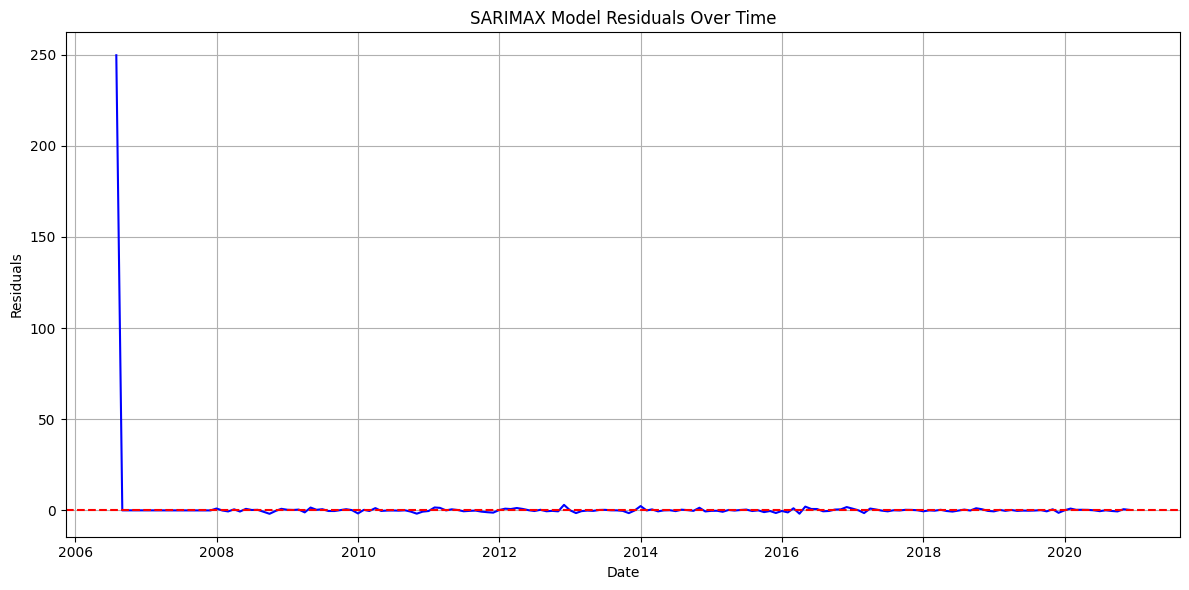

In [48]:
# Copy and prepare the dataset
df_lake = df.copy()
df_lake['Date'] = pd.to_datetime(df_lake['Date'])
df_lake.set_index('Date', inplace=True)

# Resample target variable: Actual Lake Level (monthly mean)
y_monthly = df_lake["Actual_Lake_Level"].resample("M").mean()

# Resample exogenous variables (monthly mean)
exog_monthly = df_lake[['Mean_Rainfall', 'Mean_Temp', 'Actual_Flow_Rate']].resample("M").mean()

# Train/Test split (80/20)
split_idx = int(len(y_monthly) * 0.8)
y_train = y_monthly.iloc[:split_idx]
y_test = y_monthly.iloc[split_idx:]
exog_train = exog_monthly.iloc[:split_idx]
exog_test = exog_monthly.iloc[split_idx:]

# Standardize exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

# Fit SARIMAX model
model = SARIMAX(
    y_train,
    exog=exog_train_scaled,
    order=(2, 0, 2),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results = model.fit(disp=False)

# Model summary
print(results.summary())

# Generate predictions
y_train_pred = results.fittedvalues
y_test_forecast = results.get_forecast(steps=len(y_test), exog=exog_test_scaled)
y_test_pred = y_test_forecast.predicted_mean
conf_int = y_test_forecast.conf_int()

# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_monthly, label='Actual', color='orange')
plt.plot(y_train_pred, label='Train Prediction', color='green')
plt.plot(y_test_pred, label='Test Forecast', color='red')
plt.fill_between(
    y_test_pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
    color='pink', alpha=0.3, label='95% Confidence Interval'
)
plt.axvline(y_test.index[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title('SARIMAX Forecast for Actual Lake Level with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Lake Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display coefficient significance
print("\nModel Coefficients and P-values:")
print(results.pvalues)

# Plot ACF and PACF of residuals
residuals = results.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals.dropna(), ax=axes[0])
plot_pacf(residuals.dropna(), ax=axes[1])
axes[0].set_title("Residual ACF")
axes[1].set_title("Residual PACF")
plt.tight_layout()
plt.show()

# Ljung-Box Test for residual autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("\nLjung-Box Test (lag=12):")
print(ljung_box)

# Jarque-Bera Test for residual normality
jb_stat, jb_pval, skew, kurt = jarque_bera(residuals)
print("\nJarque-Bera Test for Residuals:")
print(f"JB Statistic: {jb_stat:.2f}, p-value: {jb_pval:.4f}, Skew: {skew:.2f}, Kurtosis: {kurt:.2f}")

# Display information criteria
print("\nModel Selection Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# Evaluate forecast accuracy on the test set
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape = np.mean(np.abs((y_test - y_test_pred) / y_test.replace(0, np.nan))) * 100

print("\nForecast Accuracy on Test Set:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('SARIMAX Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()
